In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import scipy.stats as stats

from scipy.interpolate import griddata

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [4]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

#### Simulation of field trip

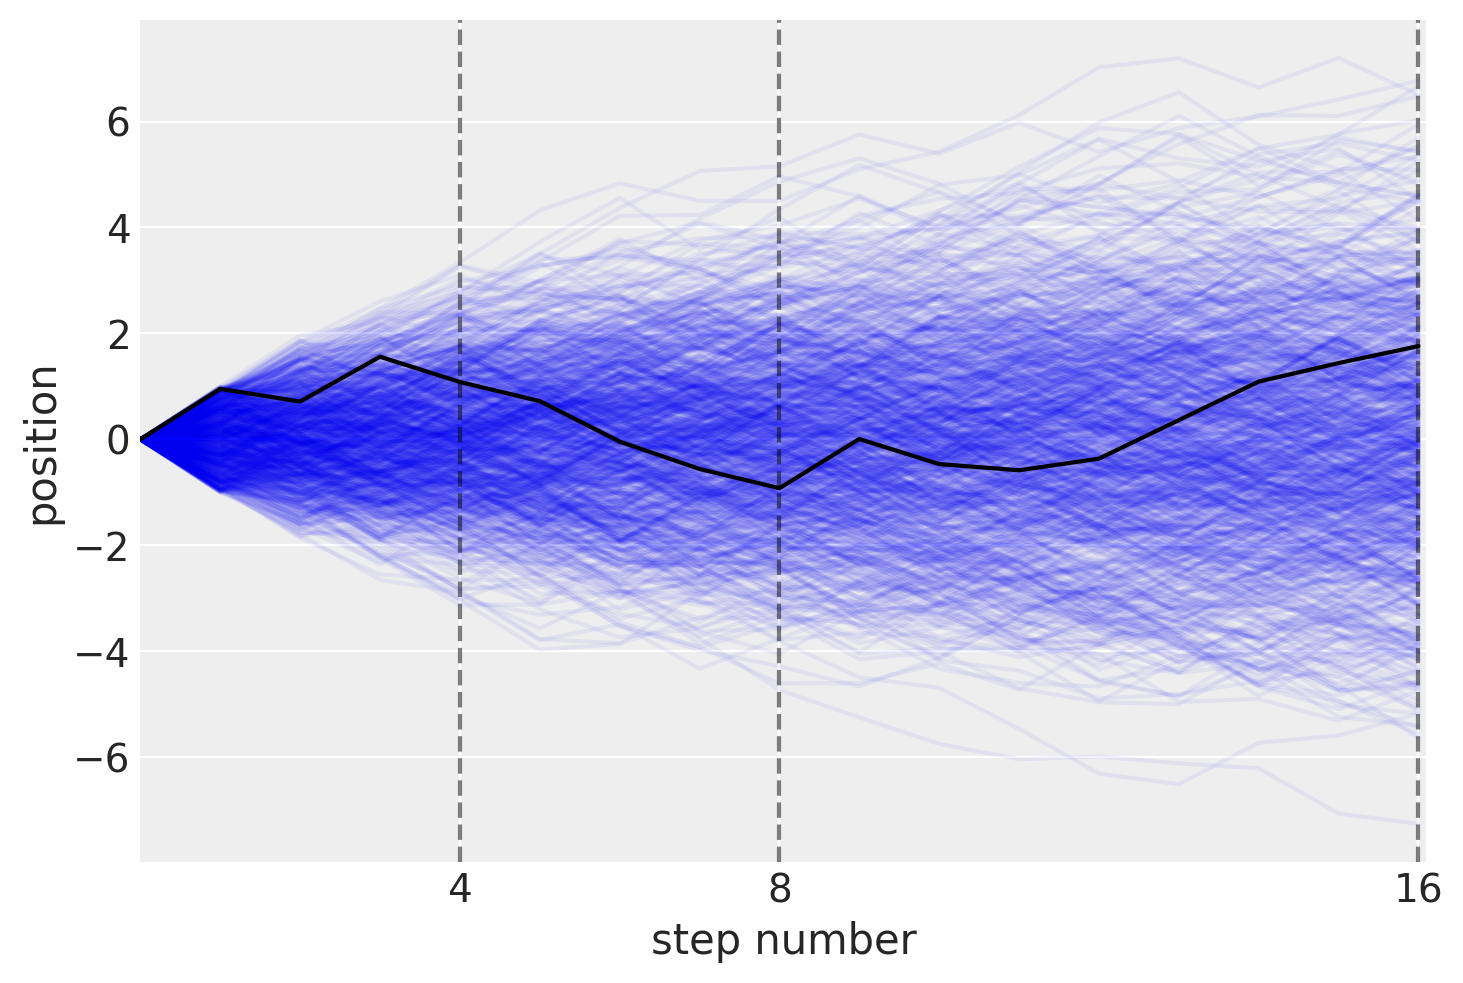

In [5]:
# пример показывает что даже случайные блуждания из равномерного распределения
# приводят нас в координаты, которые распределены нормально
# от себя добавлю что это ссылает нас к Central limit theorem

step_rng = np.random.default_rng(1234)

steps = 16
repetitions = 1000
show_steps = [4, 8, 16]
x = np.zeros([steps + 1, repetitions])
for i in range(x.shape[1]):
    x[1:, i] = np.cumsum(step_rng.uniform(-1, 1, steps))

fig, ax = plt.subplots()
plt.plot(range(0, steps + 1), x[:, :], c="b", alpha=0.05)
plt.plot(range(0, steps + 1), x[:, 0], c="k")
for step in show_steps:
    plt.axvline(step, linestyle="--", c="k", alpha=0.5)

plt.xlabel("step number")
plt.ylabel("position")
ax.set_xticks(show_steps)
plt.xlim(0, step + 0.1)
plt.show()

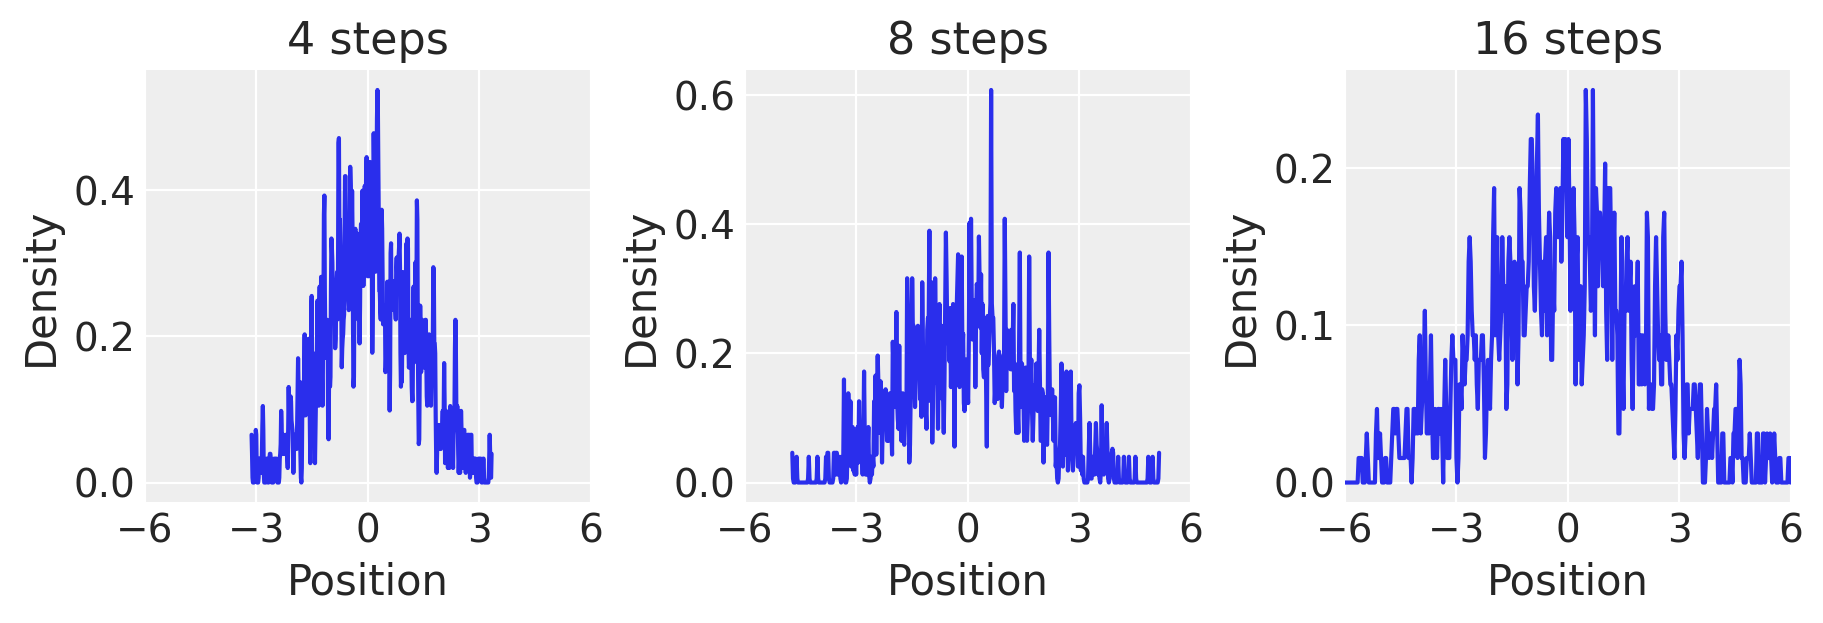

In [6]:
# данные флуктуации показывают что при больших шагах 
# распределение все больше начинает походить на нормальное распределение
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharex=True)

for step, ax in zip(show_steps, axs):
    az.plot_kde(x[step, :], bw=0.01, ax=ax)
    ax.set_title(f"{step} steps")
    ax.set_ylabel("Density")
    ax.set_xlabel("Position")
    ax.set_xlim(-6, 6)
    ax.set_xticks([-6, -3, 0, 3, 6])

#### Code 4.1

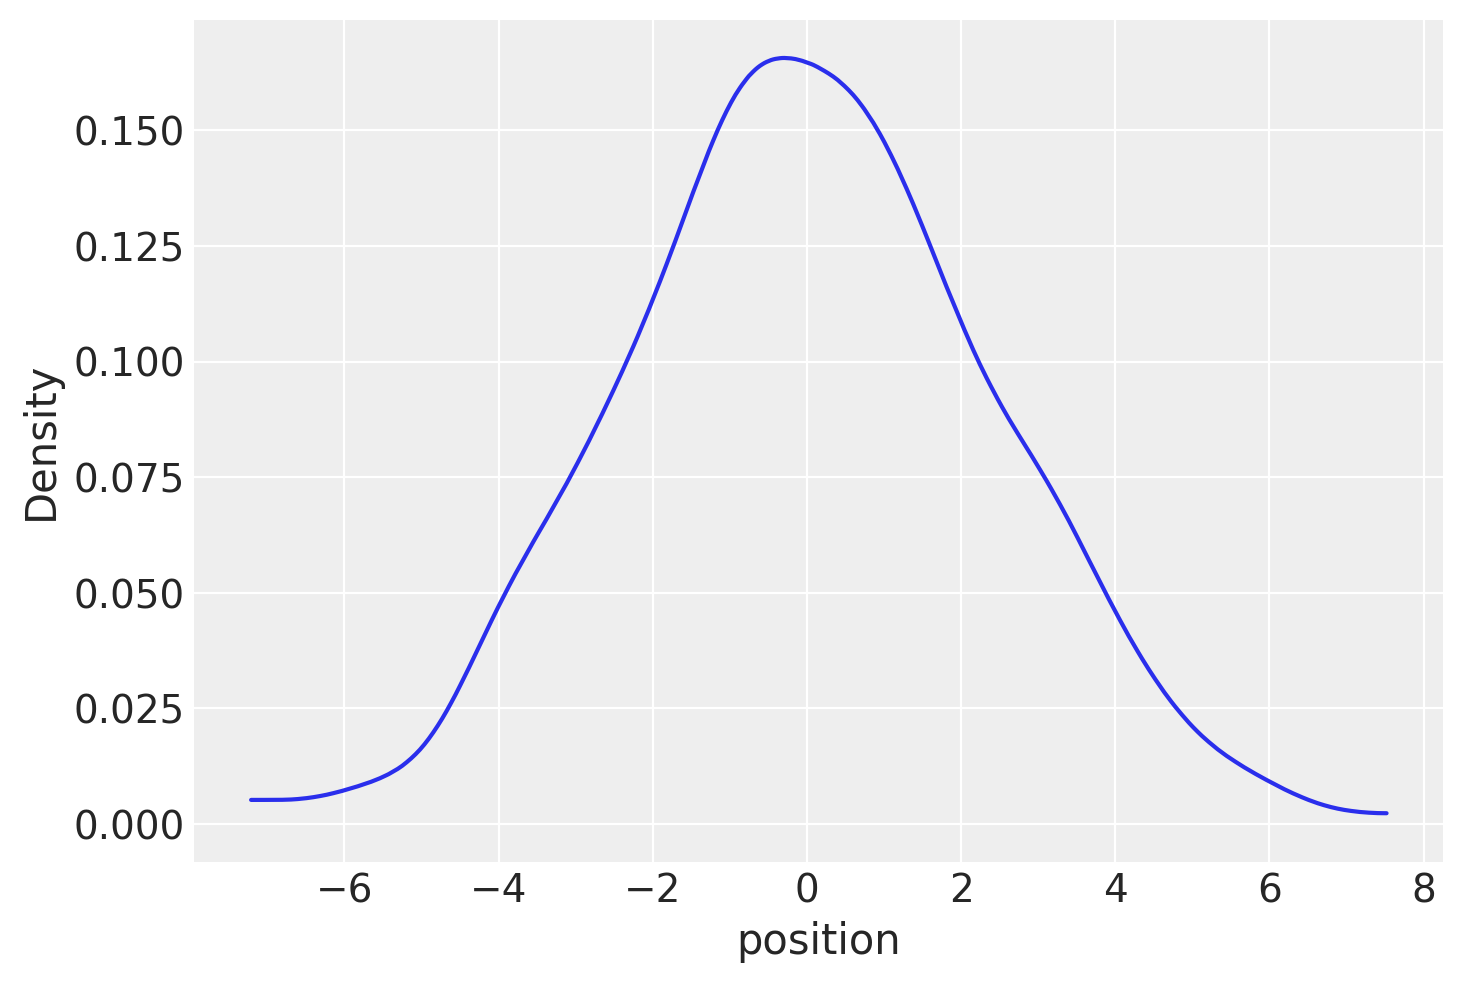

In [7]:
pos = rng.uniform(-1, 1, size=(16, 1000)).sum(0)
az.plot_kde(pos)
plt.xlabel("position")
plt.ylabel("Density");

#### Code 4.2 and 4.3

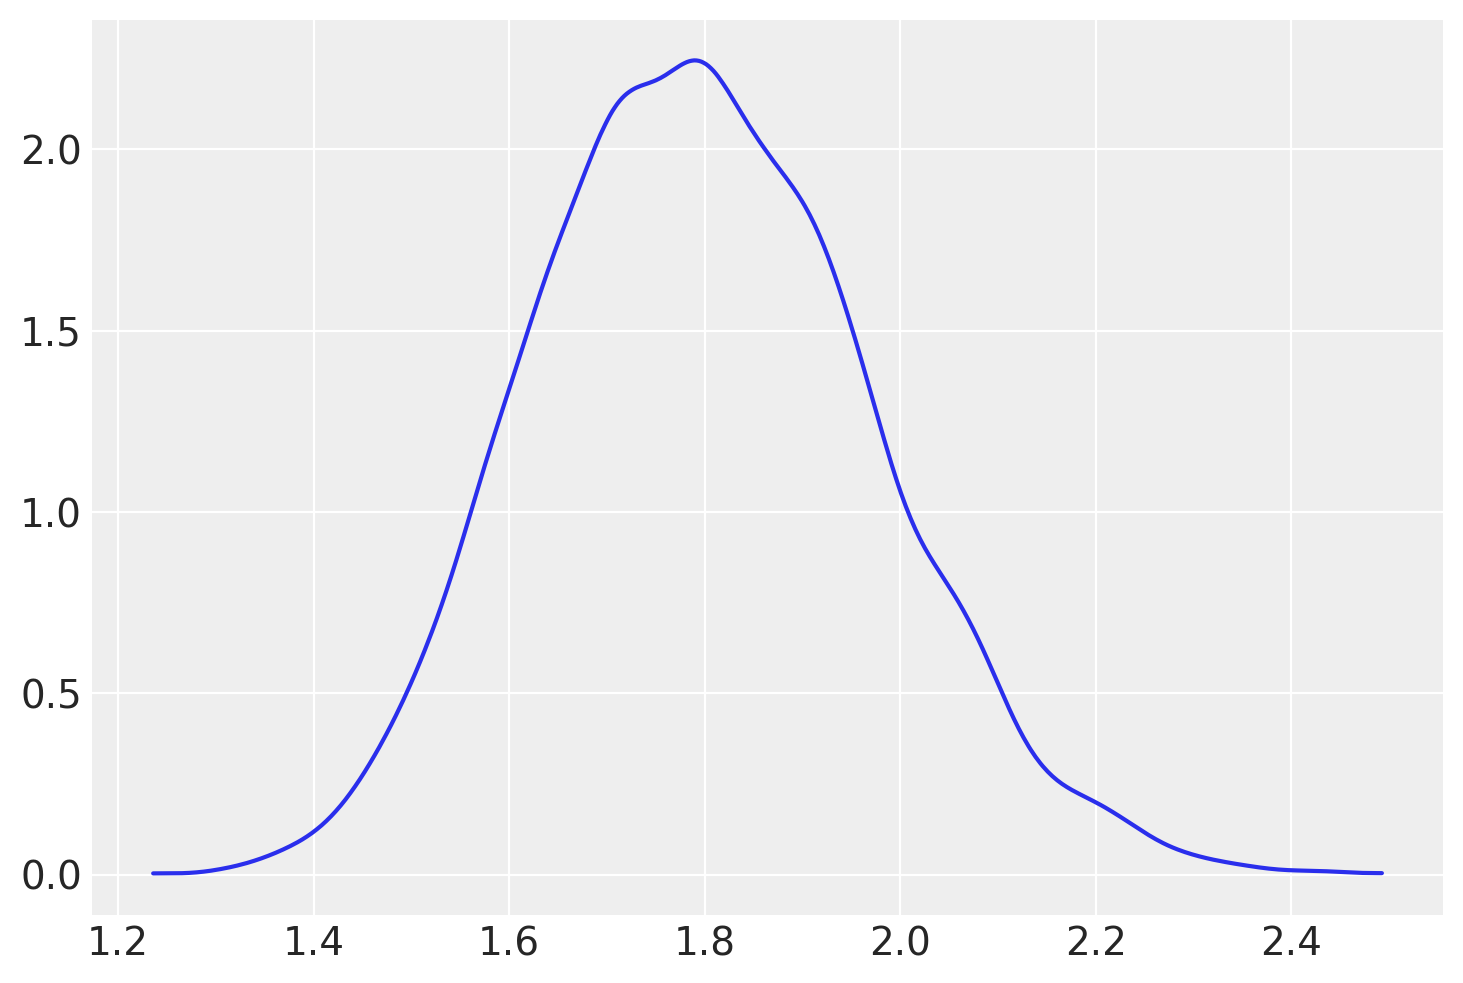

In [8]:
pos = rng.uniform(1, 1.1, size=(12, 10000)).prod(0)
az.plot_kde(pos);

#### Code 4.4

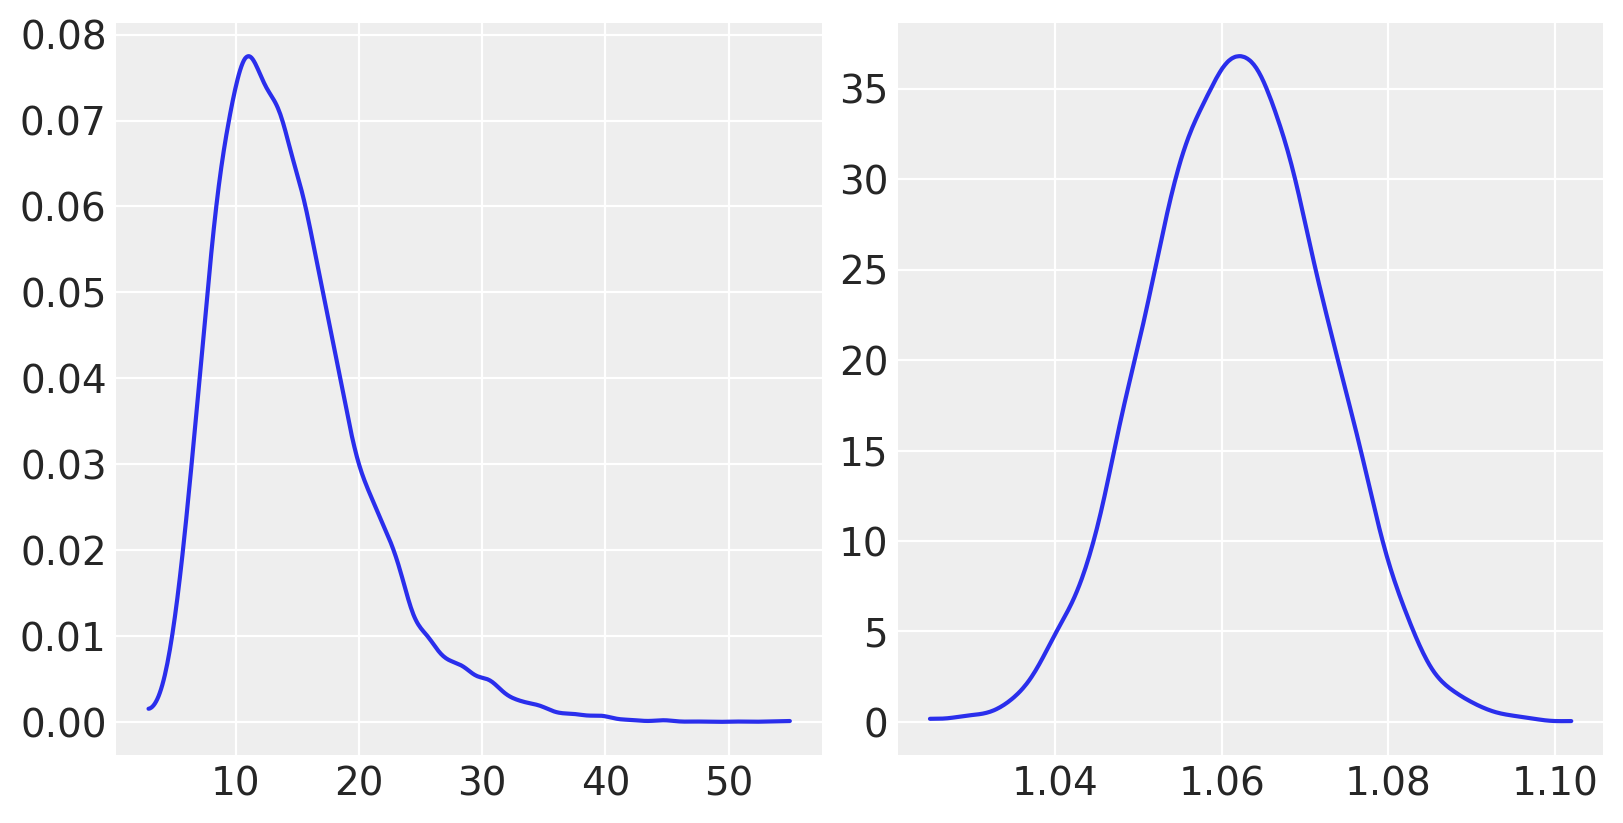

In [10]:
# при больших отклонениях мы получаем распределение мало похожее на нормальное
# но если его прологарифмировать, то все будет ок
big = rng.uniform(1, 1.5, size=(12, 10000)).prod(0)
# при маленьких отклонениях мы получаем распределение очень похожее на нормальное
small = rng.uniform(1, 1.01, size=(12, 10000)).prod(0)
_, ax = plt.subplots(1, 2, figsize=(8, 4))
az.plot_kde(big, ax=ax[0])
az.plot_kde(small, ax=ax[1]);

#### Code 4.5

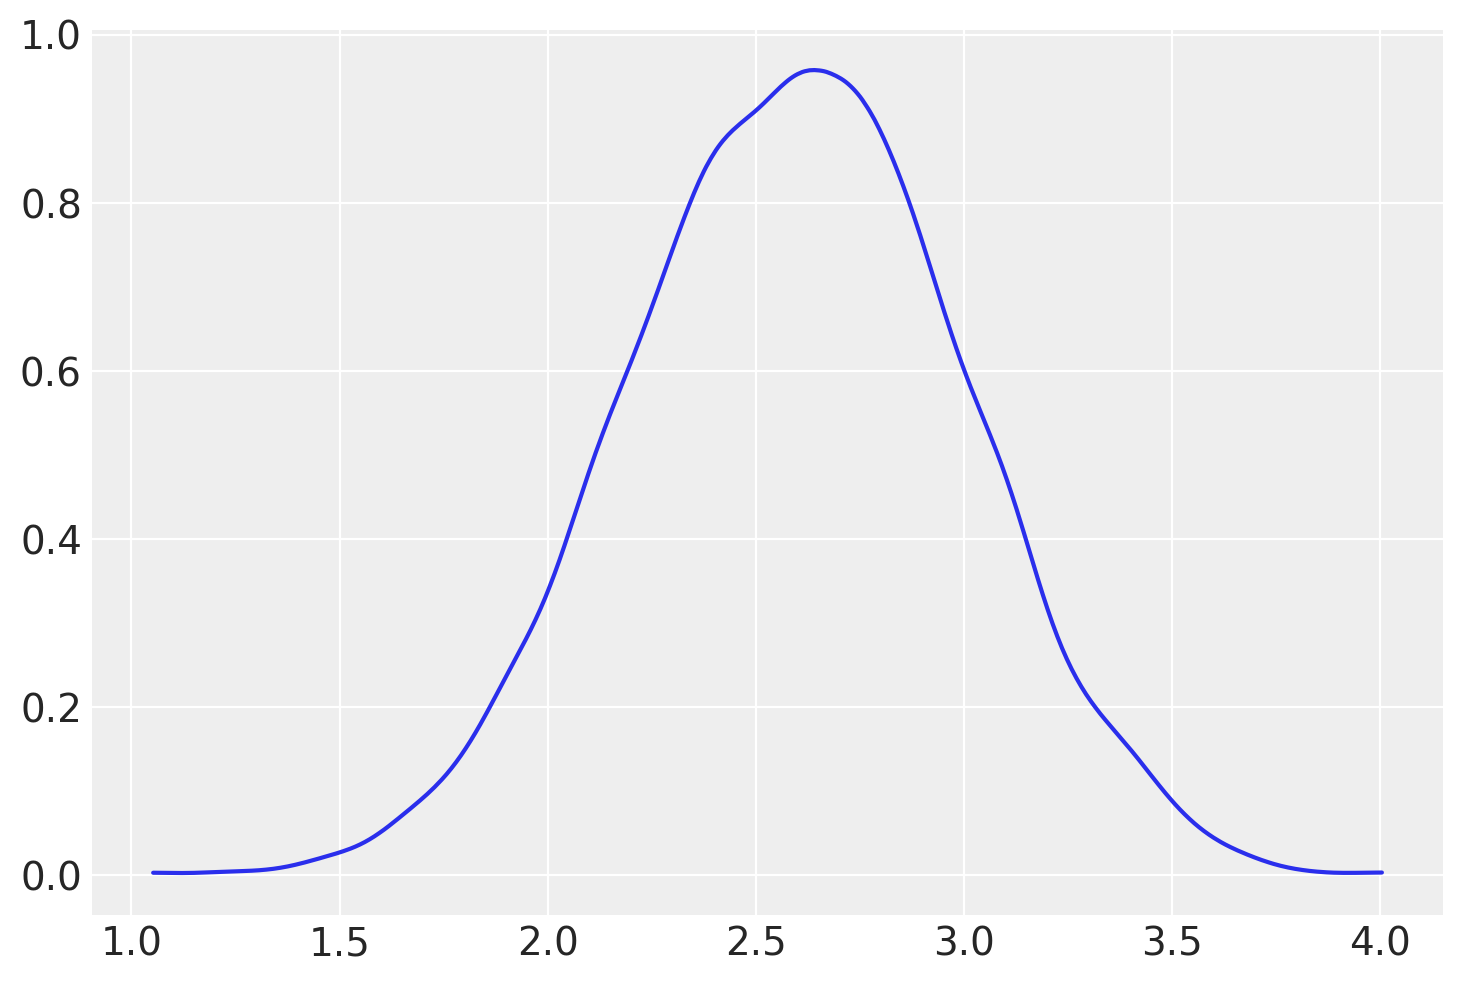

In [8]:
# отлогарифмировали значения и получили еще одно гаусово распределение
log_big = np.log(rng.uniform(1, 1.5, size=(12, 10000)).prod(0))
az.plot_kde(log_big);

#### Code 4.6

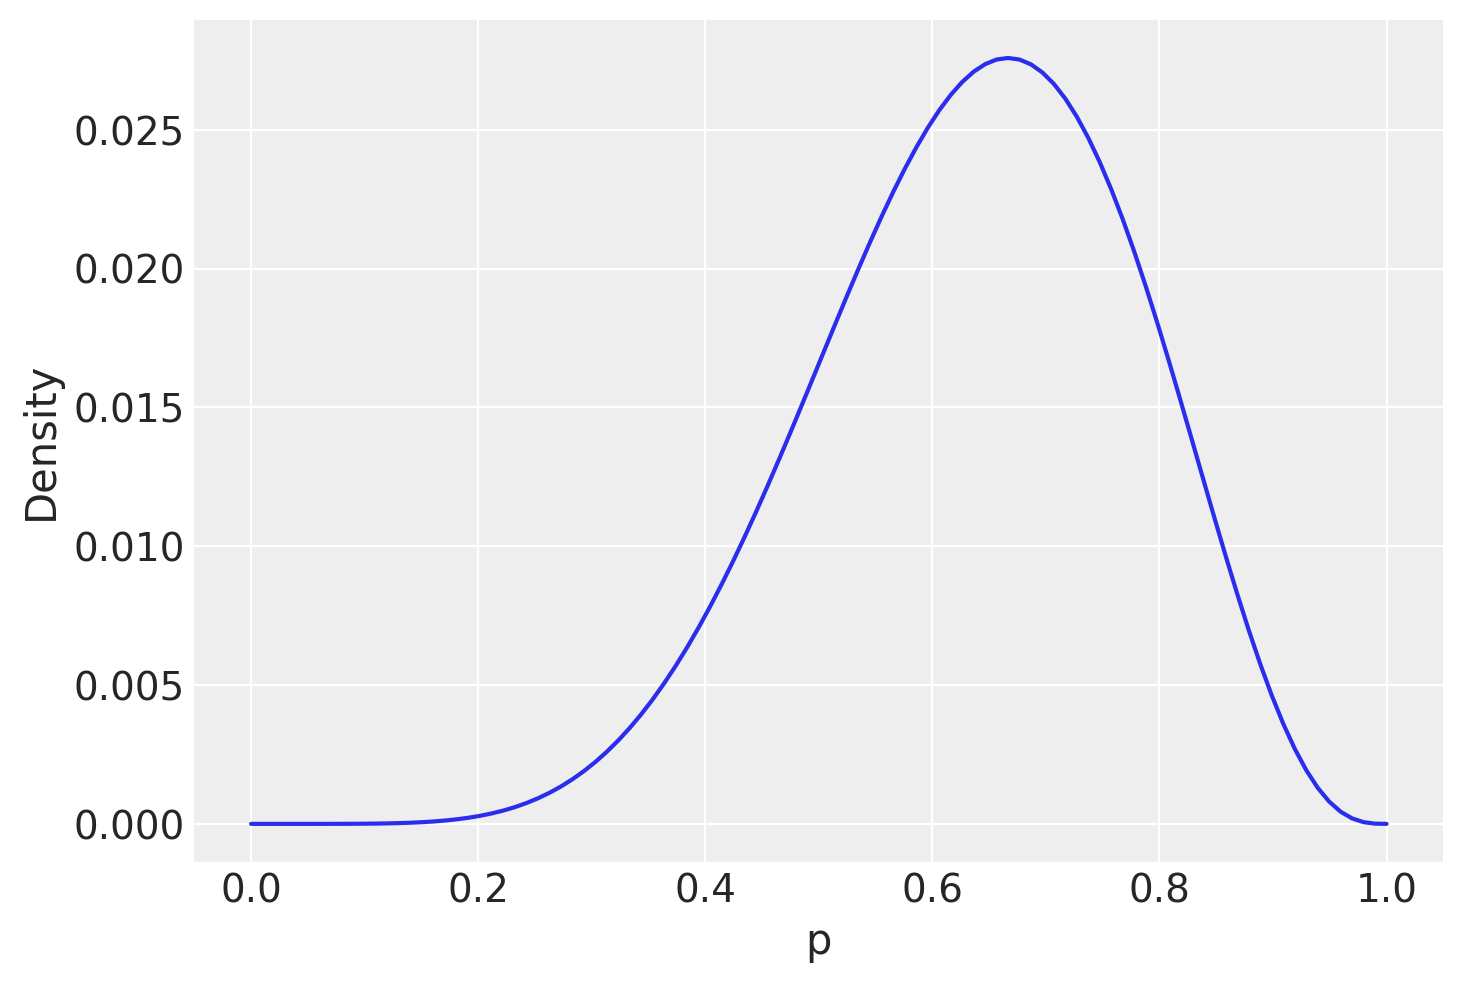

In [9]:
w, n = 6, 9
p_grid = np.linspace(0, 1, 100)
# вычисляем постериальное распределение на основе binomial и uniform 
posterior = stats.binom.pmf(k=w, n=n, p=p_grid) * stats.uniform.pdf(p_grid, 0, 1)
posterior = posterior / posterior.sum()
plt.plot(p_grid, posterior)
plt.xlabel("p")
plt.ylabel("Density");

#### Code 4.7 and 4.8

In [11]:
d = pd.read_csv("Data/Howell1.csv", sep=";", header=0)
d.head()

height     weight   age  male
0  151.765  47.825606  63.0     1
1  139.700  36.485807  63.0     0
2  136.525  31.864838  65.0     0
3  156.845  53.041914  41.0     1
4  145.415  41.276872  51.0     0

#### Code 4.9

In [12]:
az.summary(d.to_dict(orient="list"), kind="stats")

mean      sd  hdi_5.5%  hdi_94.5%
height  138.264  27.602    90.805    170.180
weight   35.611  14.719    11.368     55.707
age      29.344  20.747     0.000     57.000
male      0.472   0.500     0.000      1.000

#### Code 4.10

In [13]:
d.height

0      151.765
1      139.700
2      136.525
3      156.845
4      145.415
        ...   
539    145.415
540    162.560
541    156.210
542     71.120
543    158.750
Name: height, Length: 544, dtype: float64

#### Code 4.11

In [14]:
d2 = d[d.age >= 18]

#### Code 4.12

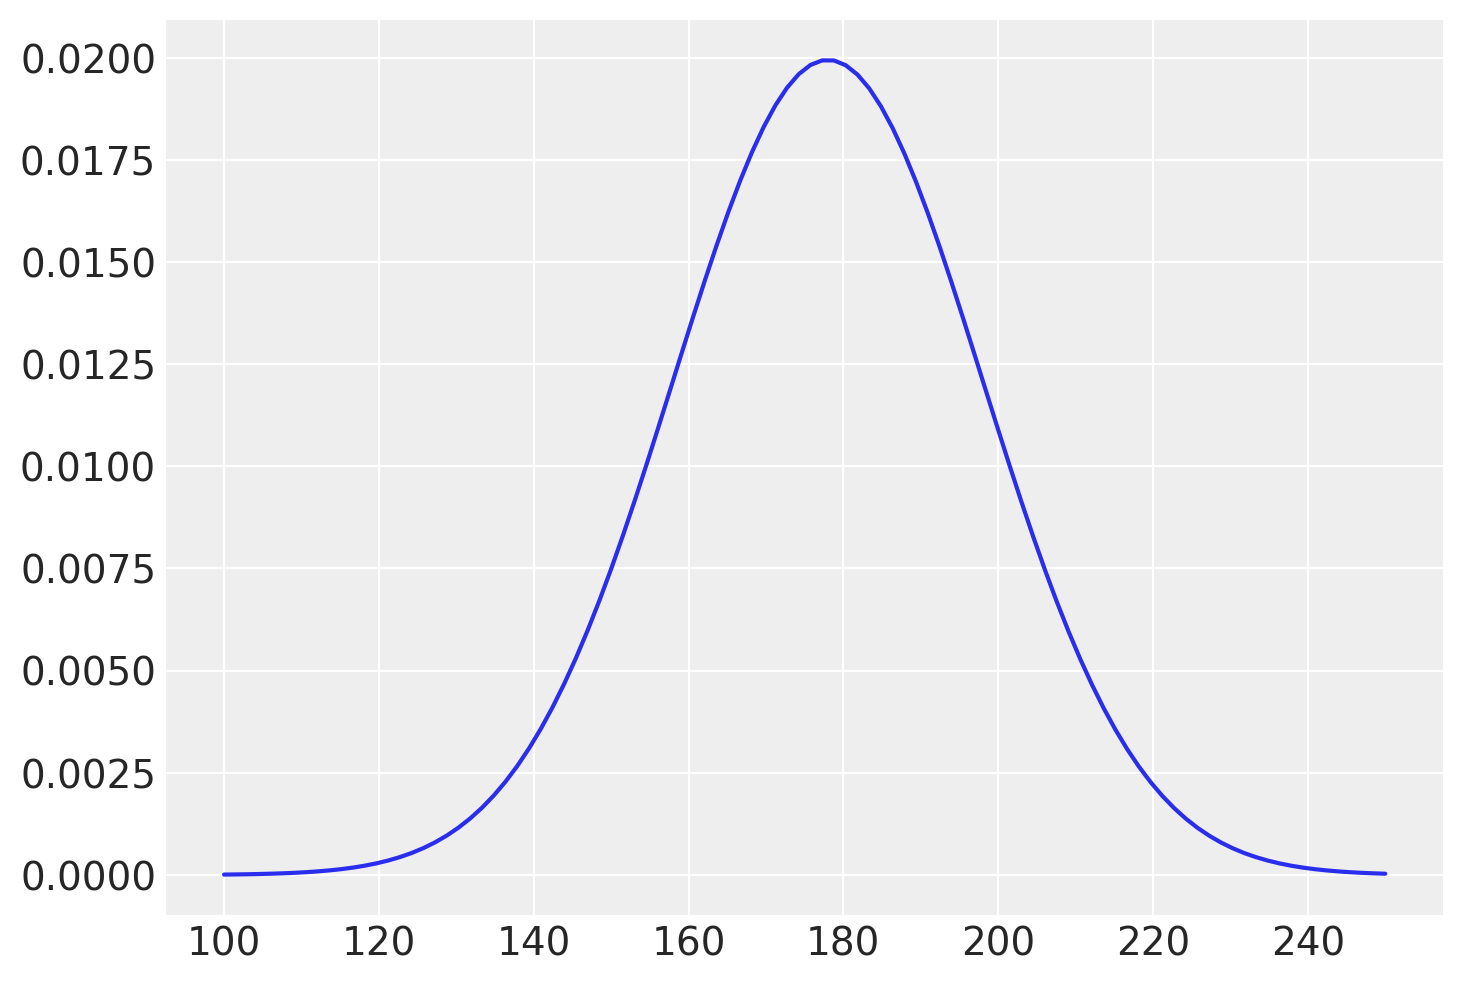

In [15]:
# печатаем наш prior, предполагая что данные имею gauss distribution 
# со следующими параметрами
x = np.linspace(100, 250, 100)
plt.plot(x, stats.norm.pdf(x, 178, 20));

#### Code 4.13

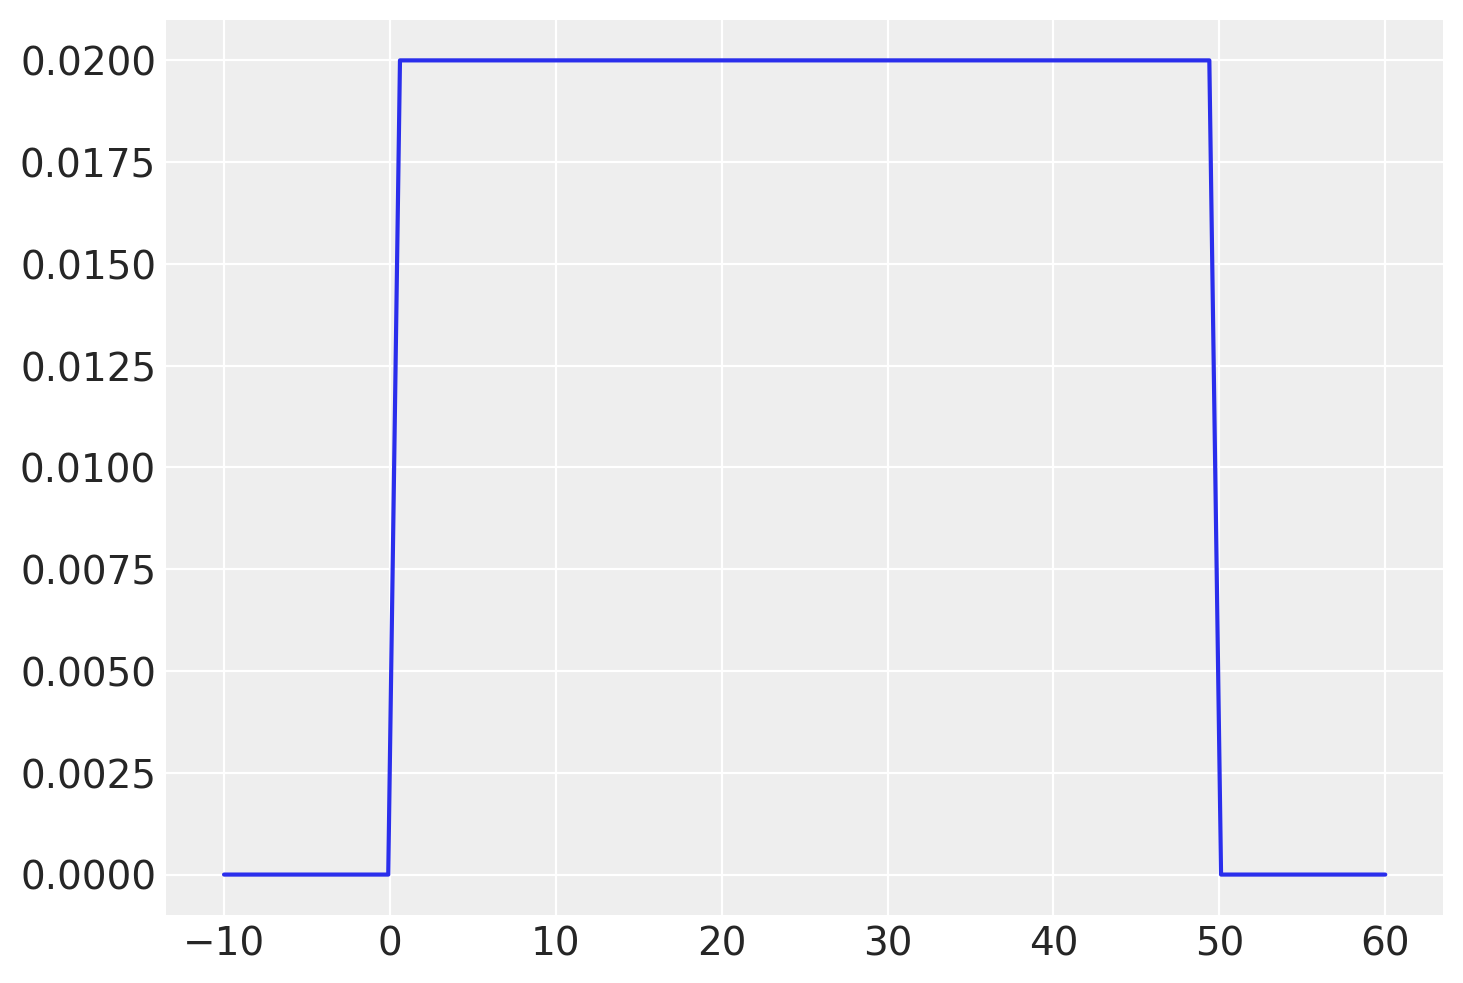

In [15]:
# печатаем наш prior, предполагая что данные имею uniform distribution 
# со следующими параметрами
x = np.linspace(-10, 60, 100)
plt.plot(x, stats.uniform.pdf(x, 0, 50));

#### Code 4.14

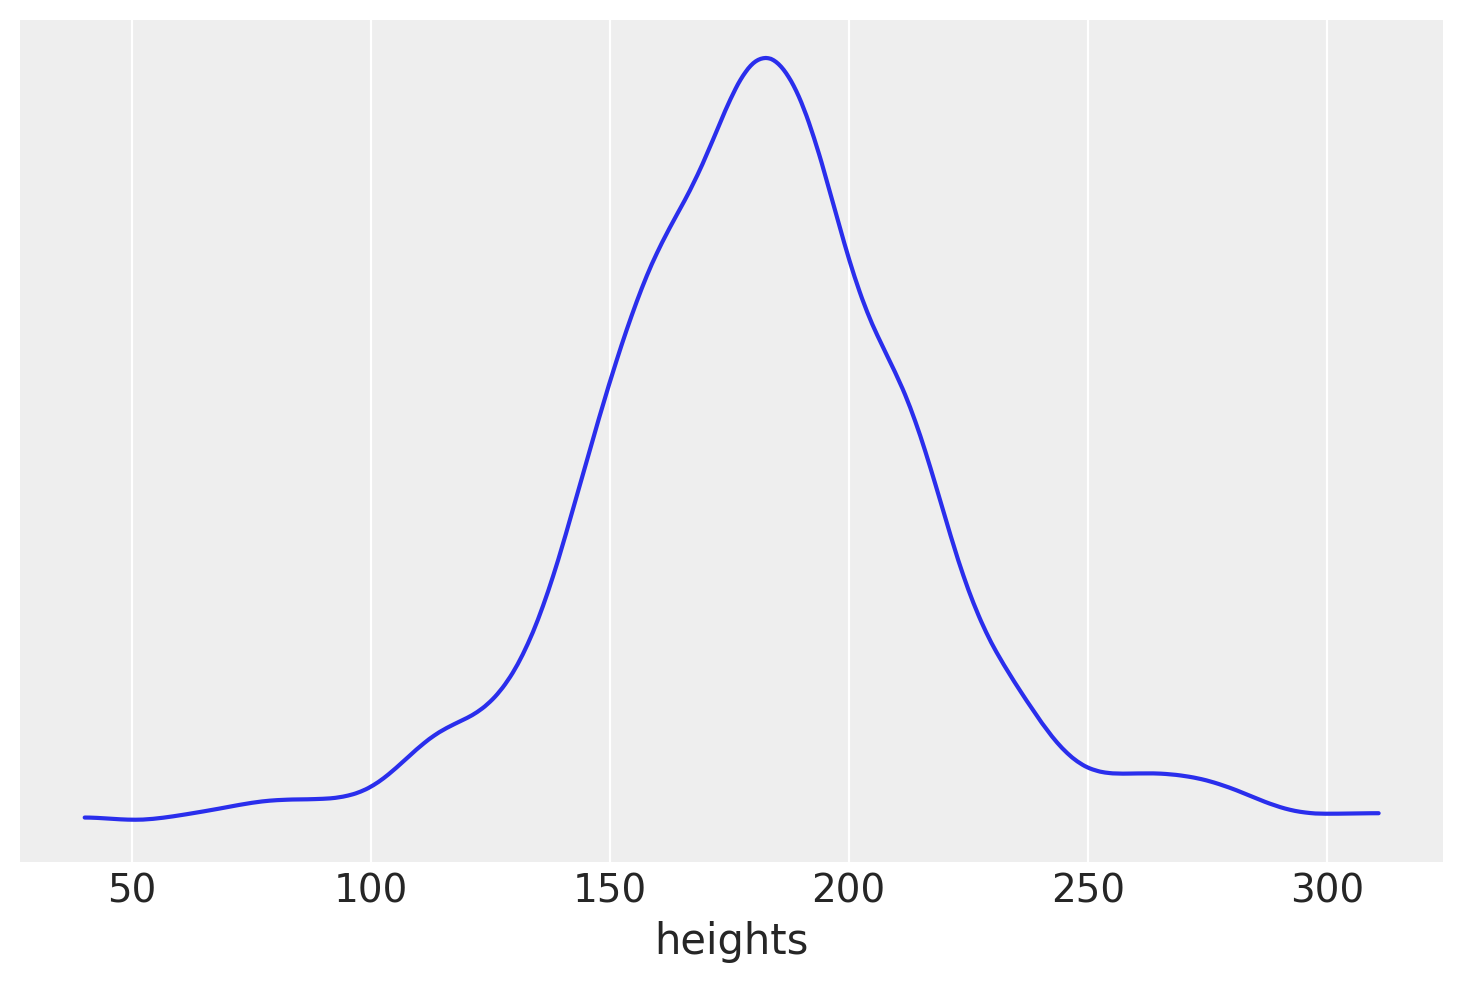

In [16]:
# Prior predictive simulation for the height model.
# где параметры для mu 170, 20(mean, std)
n_samples = 1000
sample_mu = stats.norm.rvs(loc=178, scale=20, size=n_samples)
sample_sigma = stats.uniform.rvs(loc=0, scale=50, size=n_samples)
prior_h = stats.norm.rvs(loc=sample_mu, scale=sample_sigma)
az.plot_kde(prior_h)
plt.xlabel("heights")
plt.yticks([]);

#### Code 4.15

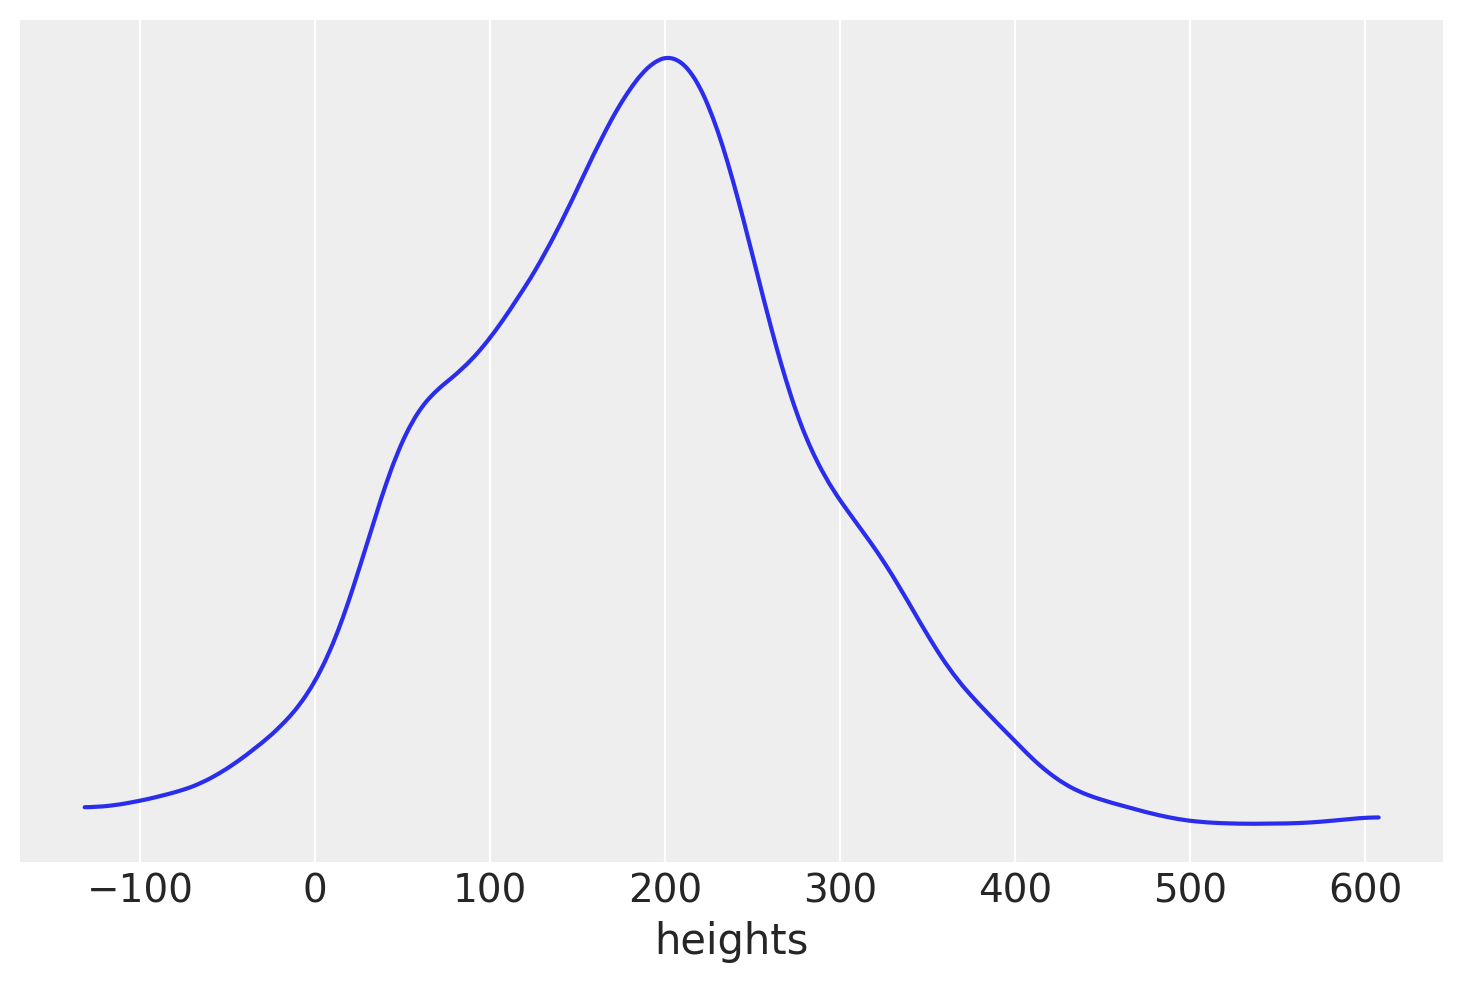

In [17]:
# где параметры для mu 170, 100(mean, std)
n_samples = 1000
sample_mu = stats.norm.rvs(loc=178, scale=100, size=n_samples)
prior_h = stats.norm.rvs(loc=sample_mu, scale=sample_sigma)
az.plot_kde(prior_h)
plt.xlabel("heights")
plt.yticks([]);

Prior predictive simulation is very useful for assigning sensible priors, because it can be
quite hard to anticipate how priors influence the observable variables. As an example, consider 
a much flatter and less informative prior for µ, like µ ∼ Normal(178, 100). Priors with
such large standard deviations are quite common in Bayesian models, but they are hardly
ever sensible.

#### Code 4.16

In [31]:
post = np.mgrid[150:160:0.05, 7:9:0.05].reshape(2, -1).T

print(f"post len = {len(post)}")
print(post)
print(f"post[:, 0][0]={post[:, 0][0]}")
print(f"post[:, 1][0]={post[:, 1][0]}")
print(f"d2.height={d2.height.loc[:5]}")
# stats.norm.logpdf - Log of the probability density function at x of the given RV
# 
print(f"stats.norm.logpdf(d2.height, loc=150, scale=7))={stats.norm.logpdf(d2.height, loc=150, scale=7)[:5]}")
likelihood = [
    sum(stats.norm.logpdf(d2.height, loc=post[:, 0][i], scale=post[:, 1][i]))
    for i in range(len(post))
]

post_prod = (
    likelihood
    + stats.norm.logpdf(post[:, 0], loc=178, scale=20)
    + stats.uniform.logpdf(post[:, 1], loc=0, scale=50)
)
post_prob = np.exp(post_prod - max(post_prod))
print(post_prob)

post len = 8000
[[150.     7.  ]
 [150.     7.05]
 [150.     7.1 ]
 ...
 [159.95   8.85]
 [159.95   8.9 ]
 [159.95   8.95]]
post[:, 0][0]=150.0
post[:, 1][0]=7.0
d2.height=0    151.765
1    139.700
2    136.525
3    156.845
4    145.415
5    163.830
Name: height, dtype: float64
stats.norm.logpdf(d2.height, loc=150, scale=7))=[-2.89663669 -3.9473997  -4.71766118 -3.34295098 -3.07936118]
[1.95774597e-35 9.71687726e-35 4.50228456e-34 ... 3.99523704e-31
 5.09561418e-31 6.33163222e-31]


#### Code 4.17

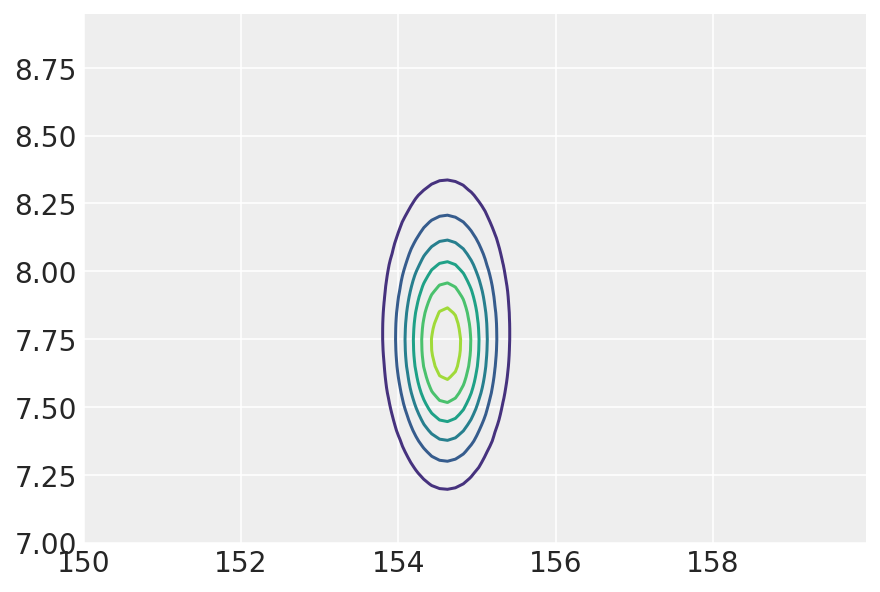

In [20]:
xi = np.linspace(post[:, 0].min(), post[:, 0].max(), 100)
yi = np.linspace(post[:, 1].min(), post[:, 1].max(), 100)
zi = griddata((post[:, 0], post[:, 1]), post_prob, (xi[None, :], yi[:, None]))

plt.contour(xi, yi, zi);

#### Code 4.18

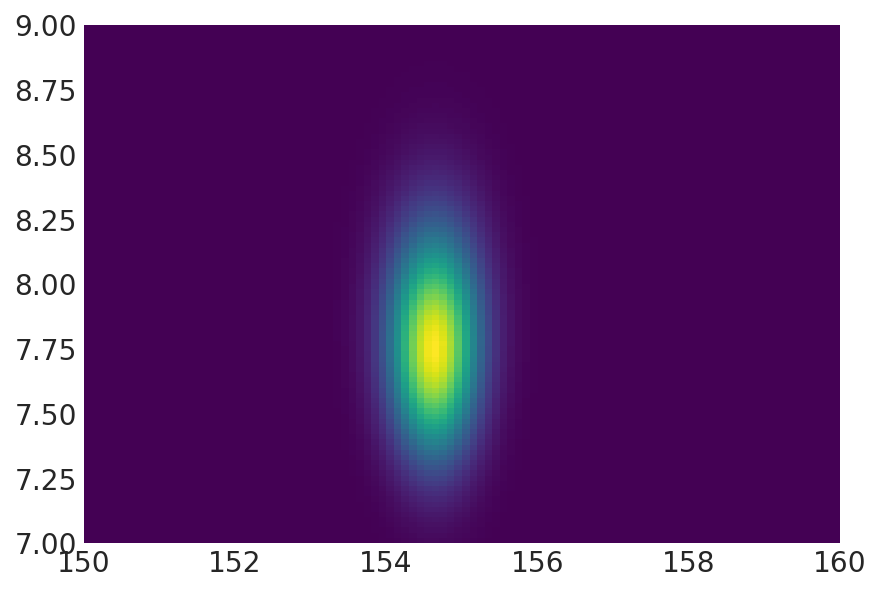

In [21]:
_, ax = plt.subplots()
ax.imshow(zi, origin="lower", extent=[150.0, 160.0, 7.0, 9.0], aspect="auto")
ax.grid(False)

#### Code 4.19 and 4.20

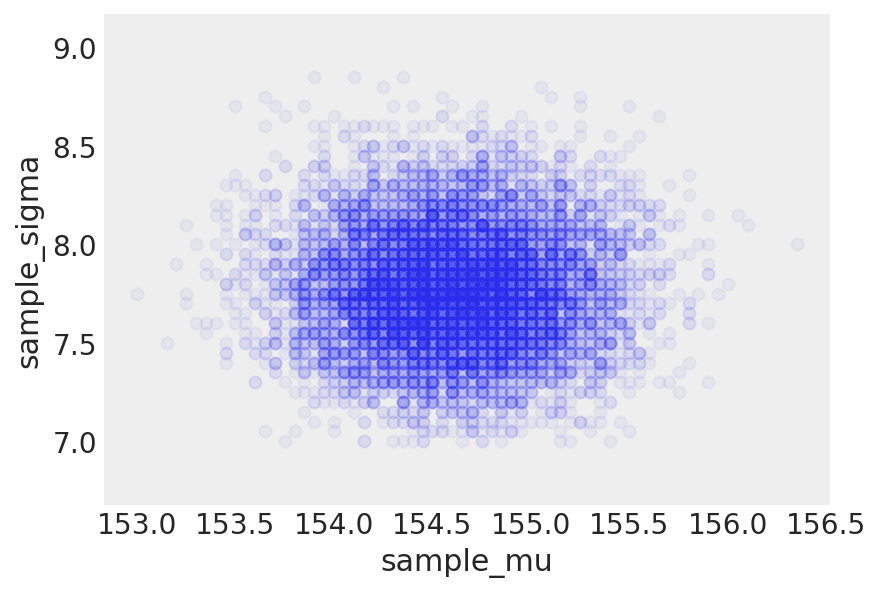

In [22]:
sample_rows = rng.choice(
    np.arange(len(post)), size=10000, replace=True, p=(post_prob / post_prob.sum())
)
sample_mu = post[:, 0][sample_rows]
sample_sigma = post[:, 1][sample_rows]

plt.plot(sample_mu, sample_sigma, "o", alpha=0.05)
plt.axis("equal")
plt.grid(False)
plt.xlabel("sample_mu")
plt.ylabel("sample_sigma");

#### Code 4.21

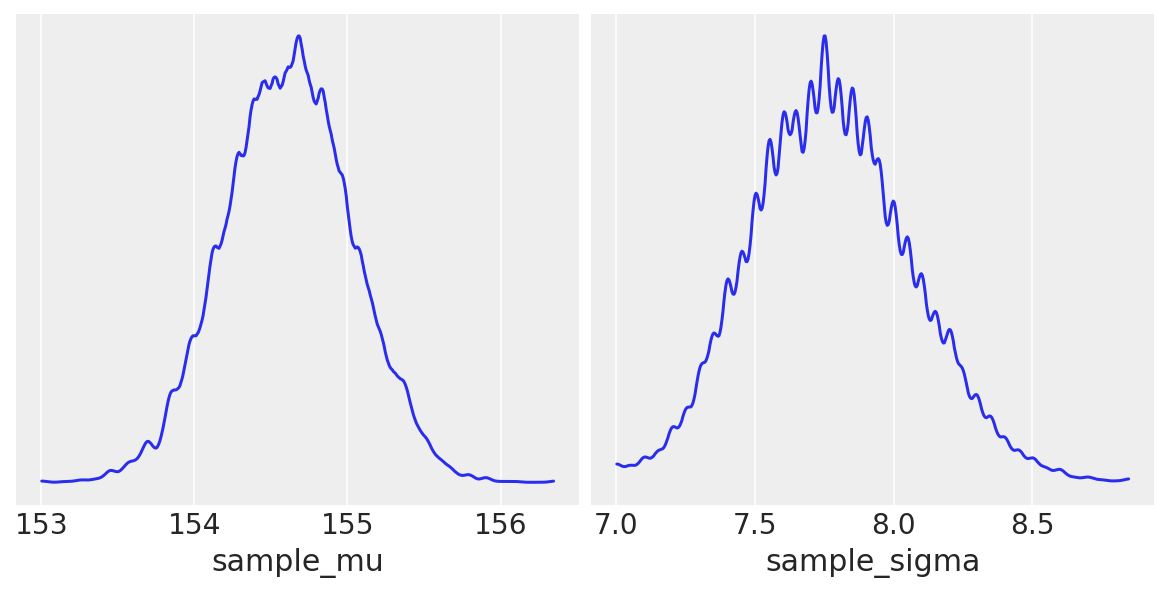

In [23]:
_, ax = plt.subplots(1, 2, figsize=(8, 4))
az.plot_kde(sample_mu, ax=ax[0])
ax[0].set_xlabel("sample_mu")
ax[0].set_yticks([])
az.plot_kde(sample_sigma, ax=ax[1])
ax[1].set_xlabel("sample_sigma")
ax[1].set_yticks([]);

#### Code 4.22

In [24]:
az.hdi(sample_mu), az.hdi(sample_sigma)

(array([153.9, 155.2]), array([7.3, 8.2]))

#### Code 4.23 and  4.24

In [25]:
d3 = rng.choice(d2.height, 20)
post2 = np.mgrid[150:170:0.1, 4:20:0.1].reshape(2, -1).T

likelihood2 = [
    sum(stats.norm.logpdf(d3, loc=post2[:, 0][i], scale=post2[:, 1][i])) for i in range(len(post2))
]

post_prod2 = (
    likelihood2
    + stats.norm.logpdf(post2[:, 0], loc=178, scale=20)
    + stats.uniform.logpdf(post2[:, 1], loc=0, scale=50)
)

post_prob2 = np.exp(post_prod2 - max(post_prod2))

sample_rows2 = rng.choice(
    np.arange(len(post2)), size=10000, replace=True, p=(post_prob2 / post_prob2.sum())
)
sample_mu2 = post2[:, 0][sample_rows2]
sample_sigma2 = post2[:, 1][sample_rows2]

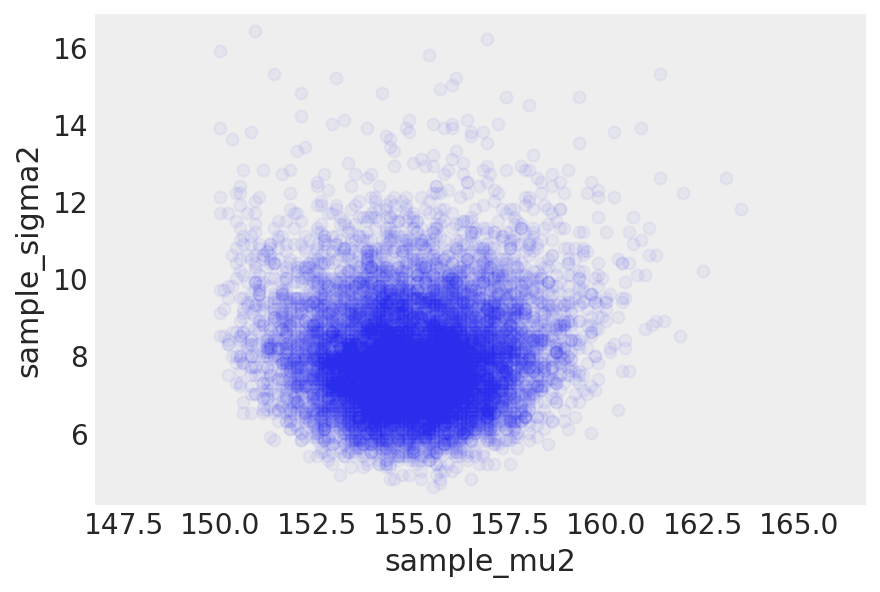

In [26]:
plt.plot(sample_mu2, sample_sigma2, "o", alpha=0.05)
plt.axis("equal")
plt.xlabel("sample_mu2")
plt.ylabel("sample_sigma2")
plt.grid(False);

#### Code 4.25

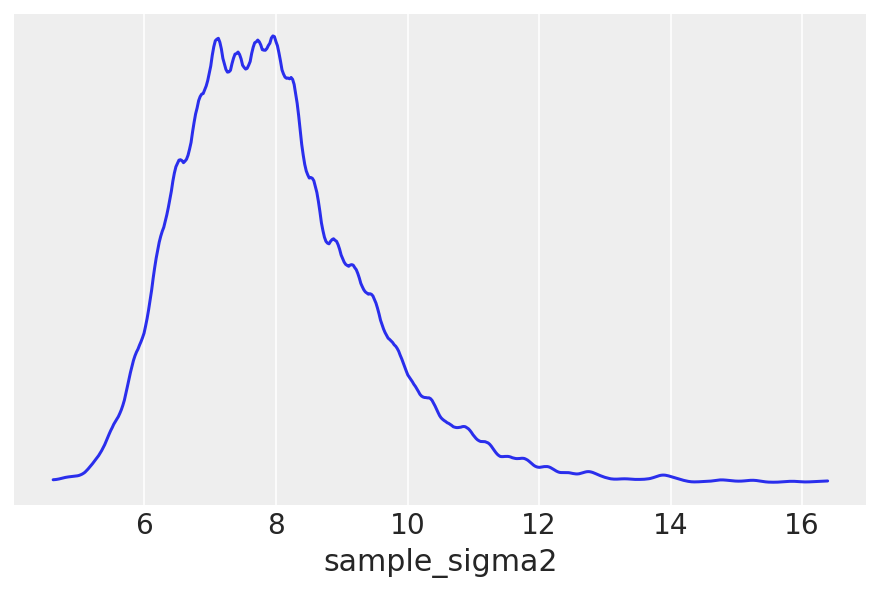

In [27]:
az.plot_kde(sample_sigma2)
plt.xlabel("sample_sigma2")
plt.yticks([]);

#### Code 4.26

We are repeating code 4.7, 4.8 and 4.10

In [28]:
d = pd.read_csv("Data/Howell1.csv", sep=";", header=0)
d2 = d[d.age >= 18]

#### Code 4.27

In [29]:
with pm.Model() as m4_1:
    mu = pm.Normal("mu", mu=178, sigma=20)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d2.height.values)

#### Code 4.28

We could use a quadratic approximation like McElreath does in his book and we did in code 2.6. But Using PyMC is really simple to just sample from the model using a "sampler method". Most common sampler methods are members of the Markov Chain Monte Carlo Method (MCMC) family (for details read Section 2.4.3 and Chapter 8 of Statistical Rethinking).

PyMC comes with various samplers. Some samplers are more suited than others for certain type of variable (and/or problems). For now we are going to let PyMC choose the sampler for us. PyMC also tries to provide a reasonable starting point for the simulation. By default PyMC uses the same adaptive procedure as in STAN `'jitter+adapt_diag'`, which starts with a identity mass matrix and then adapts a diagonal based on the variance of the tuning samples. 

You can read more details of PyMC [here](http://pymc-devs.github.io/pymc/notebooks/getting_started.html)

In [30]:
with m4_1:
    trace_4_1 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


array([[<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

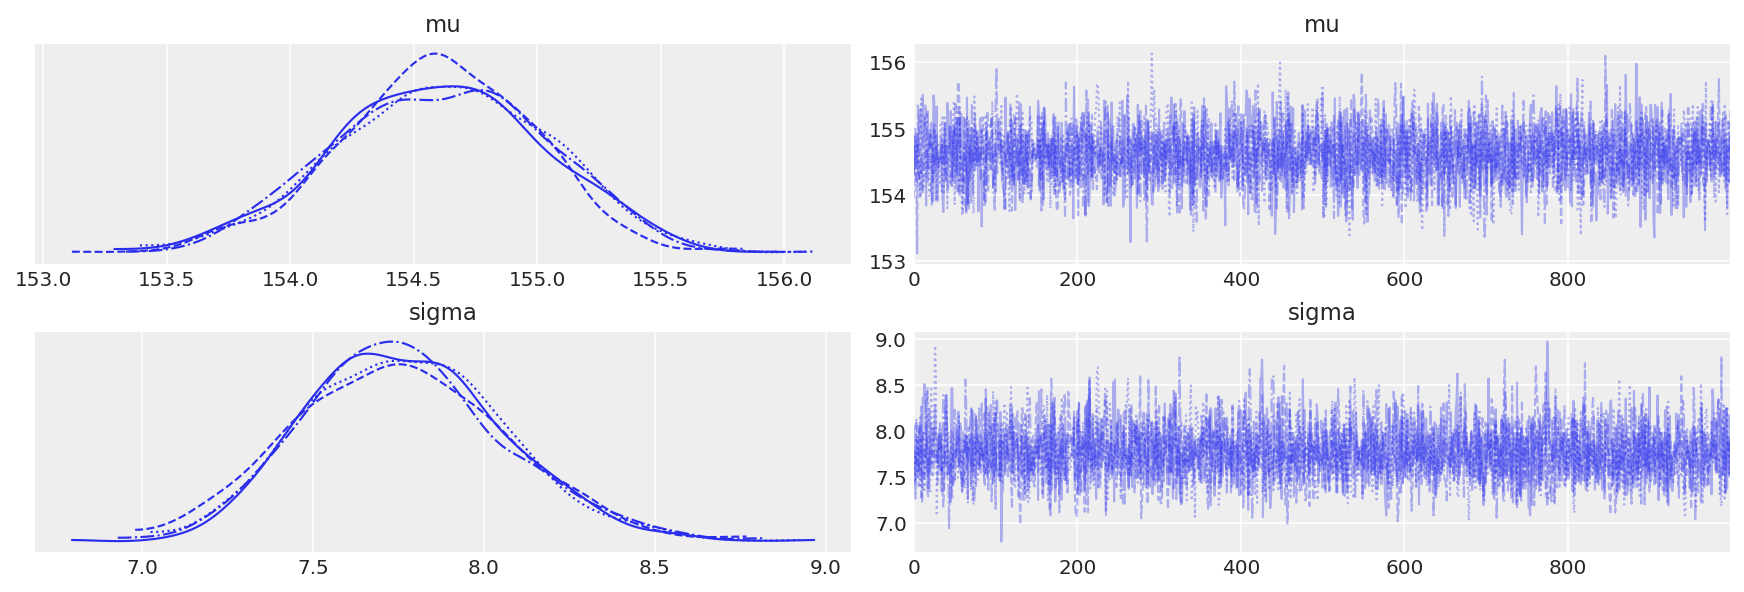

In [31]:
az.plot_trace(trace_4_1)
# this function lets you check the samples values

#### Code 4.29

In [32]:
az.summary(trace_4_1, round_to=2, kind="stats")

mean    sd  hdi_5.5%  hdi_94.5%
mu     154.61  0.42    153.97     155.30
sigma    7.77  0.29      7.33       8.26

#### Code 4.30

In [33]:
with pm.Model() as m4_1:
    mu = pm.Normal("mu", mu=178, sigma=20, testval=d2.height.mean())
    sigma = pm.Uniform("sigma", lower=0, upper=50, testval=d2.height.std())
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d2.height.values)
    trace_4_1 = pm.sample(1000, tune=1000)

C:\Users\mason\AppData\Local\Temp\ipykernel_4580\3363333656.py:2: FutureWarning: The `testval` argument is deprecated; use `initval`.
  mu = pm.Normal("mu", mu=178, sigma=20, testval=d2.height.mean())
C:\Users\mason\AppData\Local\Temp\ipykernel_4580\3363333656.py:3: FutureWarning: The `testval` argument is deprecated; use `initval`.
  sigma = pm.Uniform("sigma", lower=0, upper=50, testval=d2.height.std())
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


#### Code 4.31

In [34]:
with pm.Model() as m4_2:
    mu = pm.Normal("mu", mu=178, sigma=0.1)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d2.height.values)
    trace_4_2 = pm.sample(1000, tune=1000)
az.summary(trace_4_2, round_to=2, kind="stats")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


mean    sd  hdi_5.5%  hdi_94.5%
mu     177.86  0.10    177.71     178.03
sigma   24.60  0.95     23.13      26.18

#### Code 4.32

For some computations could be nice to have the trace turned into a DataFrame, this can be done using the `trace_to_dataframe` function

In [35]:
trace_df = az.extract_dataset(trace_4_1).to_dataframe()
trace_df.cov()

mu     sigma
mu     0.175285  0.001774
sigma  0.001774  0.092522

#### Code 4.33

In [36]:
np.diag(trace_df.cov())

array([0.17528481, 0.09252158])

In [37]:
trace_df.corr()

mu     sigma
mu     1.000000  0.013933
sigma  0.013933  1.000000

#### Code 4.34

We did not use the quadratic approximation, instead we use a MCMC method to sample from the posterior. Thus, we already have samples. We can do something like

In [38]:
trace_df.head()

mu     sigma
chain draw                      
0     0     155.050436  7.343236
      1     154.493176  8.151639
      2     154.089484  7.486485
      3     155.139714  7.804984
      4     155.417140  7.524613

Or directly from the trace (we are getting the first ten samples of _sigma_)

In [39]:
trace_4_1.posterior["sigma"][0][:10]

<xarray.DataArray 'sigma' (draw: 10)>
array([7.34323595, 8.15163877, 7.48648497, 7.80498398, 7.52461322,
       7.69740715, 7.94368863, 7.82408179, 8.09849506, 7.73763309])
Coordinates:
    chain    int32 0
  * draw     (draw) int32 0 1 2 3 4 5 6 7 8 9

#### Code 4.35

In our case, this is the same we did in the code 4.27

In [40]:
az.summary(trace_4_1, round_to=2, kind="stats")

mean    sd  hdi_5.5%  hdi_94.5%
mu     154.62  0.42    153.96     155.28
sigma    7.77  0.30      7.31       8.27

#### Code 4.36

In [41]:
stats.multivariate_normal.rvs(mean=trace_df.mean(), cov=trace_df.cov(), size=10)

array([[154.6798886 ,   7.4924244 ],
       [154.68463879,   7.41817104],
       [154.5175726 ,   7.98875088],
       [154.6351805 ,   8.13631558],
       [154.89479841,   7.68834373],
       [154.59051909,   7.72712052],
       [154.47653748,   8.04462853],
       [155.17960648,   7.98027007],
       [154.90526518,   7.72169257],
       [154.59781304,   8.06361691]])

#### Code 4.37

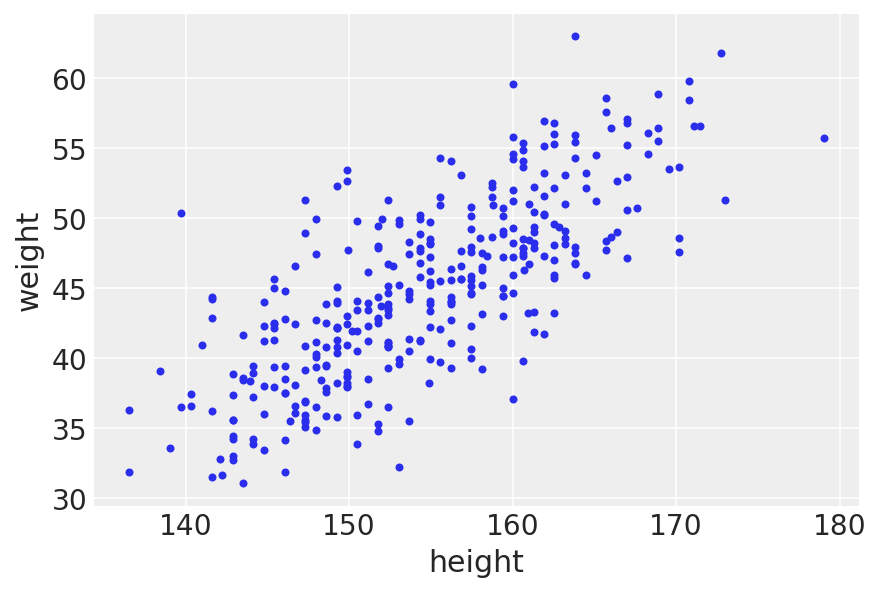

In [42]:
plt.plot(d2.height, d2.weight, ".")
plt.xlabel("height")
plt.ylabel("weight");

#### Code 4.38

In [43]:
height_rng = np.random.default_rng(2971)

N = 100  # 100 lines
a = stats.norm.rvs(178, 20, N)
b = stats.norm.rvs(0, 10, N)

#### Code 4.39 and 4.40

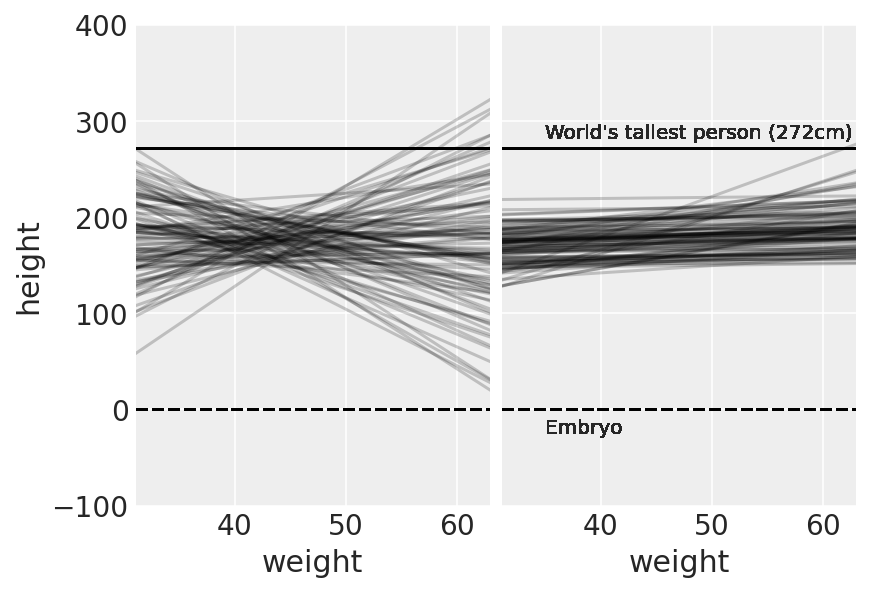

In [44]:
_, ax = plt.subplots(1, 2, sharey=True)
xbar = d2.weight.mean()
x = np.linspace(d2.weight.min(), d2.weight.max(), N)
for i in range(N):
    ax[0].plot(a[i] + b[i] * (x - xbar), "k", alpha=0.2)
    ax[0].set_xlim(d2.weight.min(), d2.weight.max())
    ax[0].set_ylim(-100, 400)
    ax[0].axhline(0, c="k", ls="--")
    ax[0].axhline(272, c="k")
    ax[0].set_xlabel("weight")
    ax[0].set_ylabel("height")

b = stats.lognorm.rvs(s=1, scale=1, size=100)
for i in range(N):
    ax[1].plot(a[i] + b[i] * (x - xbar), "k", alpha=0.2)
    ax[1].set_xlim(d2.weight.min(), d2.weight.max())
    ax[1].set_ylim(-100, 400)
    ax[1].axhline(0, c="k", ls="--", label="embryo")
    ax[1].axhline(272, c="k")
    ax[1].set_xlabel("weight")
    ax[1].text(x=35, y=282, s="World's tallest person (272cm)")
    ax[1].text(x=35, y=-25, s="Embryo");

#### Code 4.42

In [45]:
with pm.Model() as m4_3:
    a = pm.Normal("a", mu=178, sigma=20)
    b = pm.Lognormal("b", mu=0, sigma=1)
    sigma = pm.Uniform("sigma", 0, 50)
    mu = a + b * (d2.weight.values - xbar)
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d2.height.values)
    trace_4_3 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


In [46]:
with pm.Model() as m4_3b:
    a = pm.Normal("a", mu=178, sigma=20)
    b = pm.Normal("b", mu=0, sigma=1)
    sigma = pm.Uniform("sigma", 0, 50)
    mu = a + np.exp(b) * (d2.weight.values - xbar)
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d2.height.values)
    trace_4_3b = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


#### Code 4.44

In [47]:
az.summary(trace_4_3, kind="stats")

mean     sd  hdi_5.5%  hdi_94.5%
a      154.606  0.282   154.172    155.057
b        0.905  0.043     0.828      0.968
sigma    5.104  0.198     4.810      5.442

#### Code 4.45

In [48]:
trace_4_3_df = trace_4_3.posterior.to_dataframe()
trace_4_3_df.cov().round(3)

a      b  sigma
a      0.079  0.000  0.001
b      0.000  0.002 -0.000
sigma  0.001 -0.000  0.039

#### Code 4.46

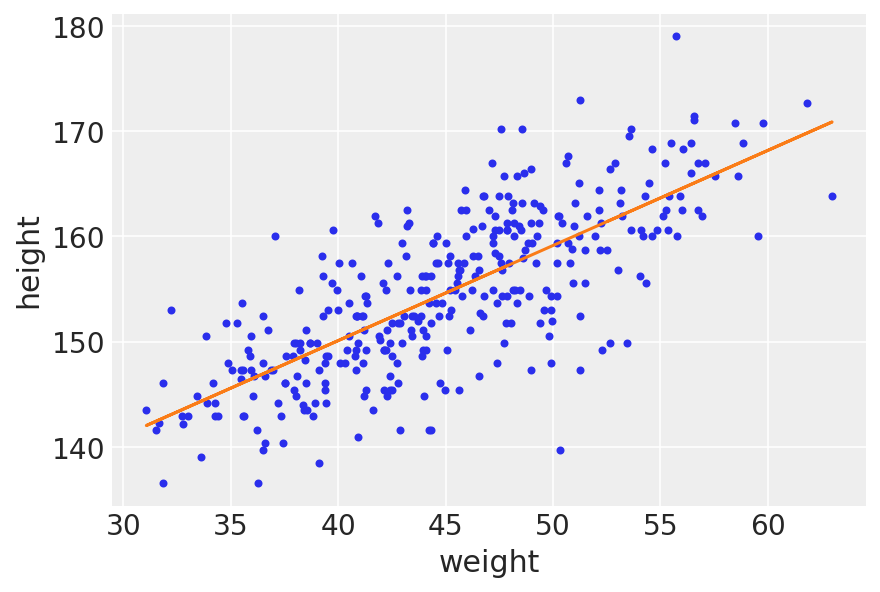

In [49]:
plt.plot(d2.weight, d2.height, ".")
plt.plot(
    d2.weight,
    trace_4_3.posterior["a"].mean().item(0)
    + trace_4_3.posterior["b"].mean().item(0) * (d2.weight - xbar),
)
plt.xlabel(d2.columns[1])
plt.ylabel(d2.columns[0]);

#### Code 4.47

In [50]:
trace_4_3_df.head(5)

a         b     sigma
chain draw                                
0     0     155.113721  0.901425  5.247865
      1     154.200506  0.914927  4.932171
      2     154.949927  0.888559  5.060933
      3     154.708366  0.926841  5.358984
      4     154.758245  0.918968  4.851755

#### Code 4.48

In [51]:
N = [10, 50, 150, 352][0]
dN = d2[:N]
with pm.Model() as m_N:
    a = pm.Normal("a", mu=178, sigma=100)
    b = pm.Lognormal("b", mu=0, sigma=1)
    sigma = pm.Uniform("sigma", 0, 50)
    mu = pm.Deterministic("mu", a + b * (dN.weight.values - dN.weight.mean()))
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=dN.height.values)
    chain_N = pm.sample(1000, tune=1000)

trace_N = az.extract_dataset(chain_N)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.


#### Code 4.49

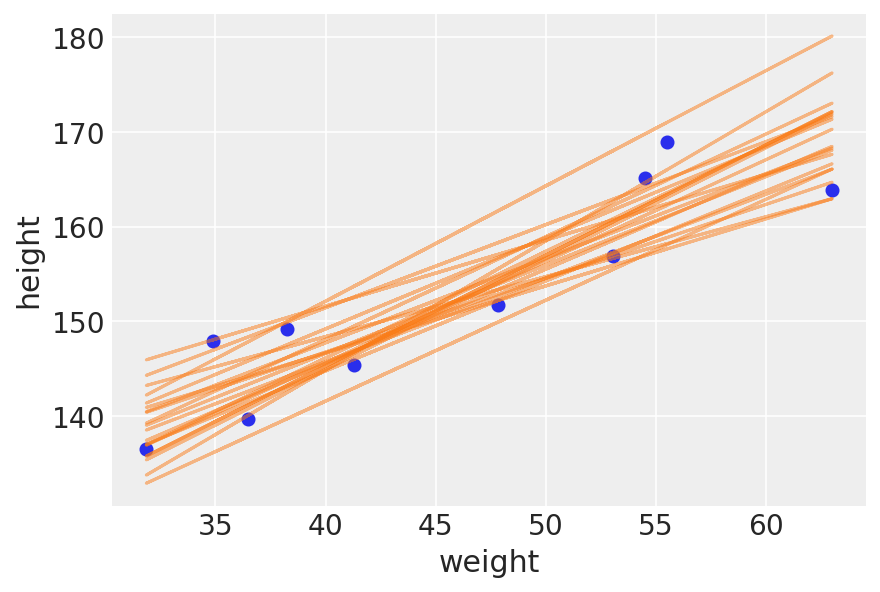

In [52]:
plt.plot(dN.weight, dN.height, "C0o")
nb_samples = trace_N.sizes["sample"]
idxs = height_rng.integers(nb_samples, size=20)
for idx in idxs:
    plt.plot(
        dN.weight,
        trace_N["a"].item(idx) + trace_N["b"].item(idx) * (dN.weight - dN.weight.mean()),
        "C1-",
        alpha=0.5,
    )
plt.xlabel(d2.columns[1])
plt.ylabel(d2.columns[0]);

Alternative we can directly use the deterministic `mu` variable

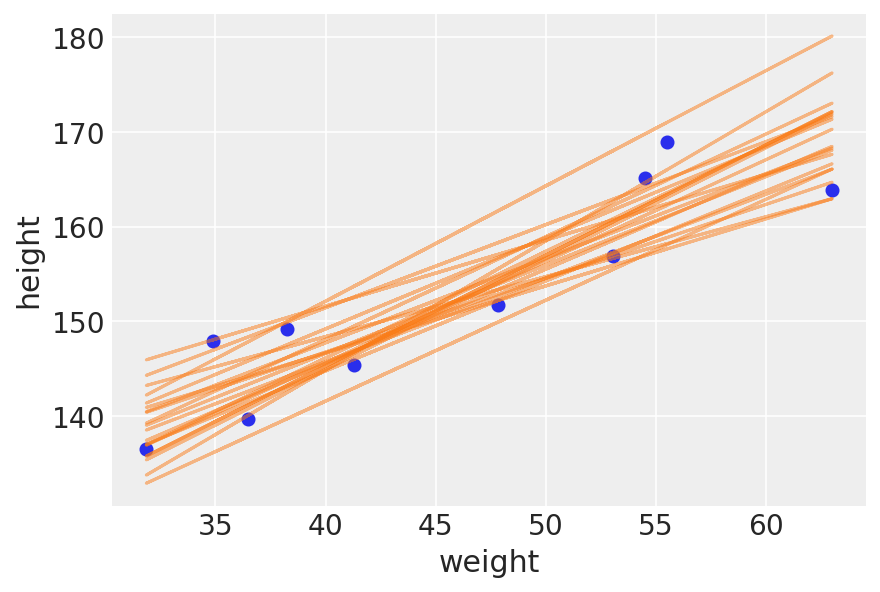

In [53]:
plt.plot(dN.weight, dN.height, "C0o")
for idx in idxs:
    plt.plot(d2.weight[:N], trace_N["mu"][:, idx], "C1-", alpha=0.5)
plt.xlabel(d2.columns[1])
plt.ylabel(d2.columns[0]);

In [54]:
N = [10, 50, 150, 352]

data = []
traces = []
for n in N:
    dN = d2[:n]
    with pm.Model() as m_N:
        a = pm.Normal("a", mu=178, sigma=100)
        b = pm.Lognormal("b", mu=0, sigma=1)
        sigma = pm.Uniform("sigma", 0, 50)
        mu = pm.Deterministic("mu", a + b * (dN.weight.values - dN.weight.mean()))
        height = pm.Normal("height", mu=mu, sigma=sigma, observed=dN.height.values)
        traces.append(pm.sample(1000, tune=1000, progressbar=False))
        data.append(dN)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.


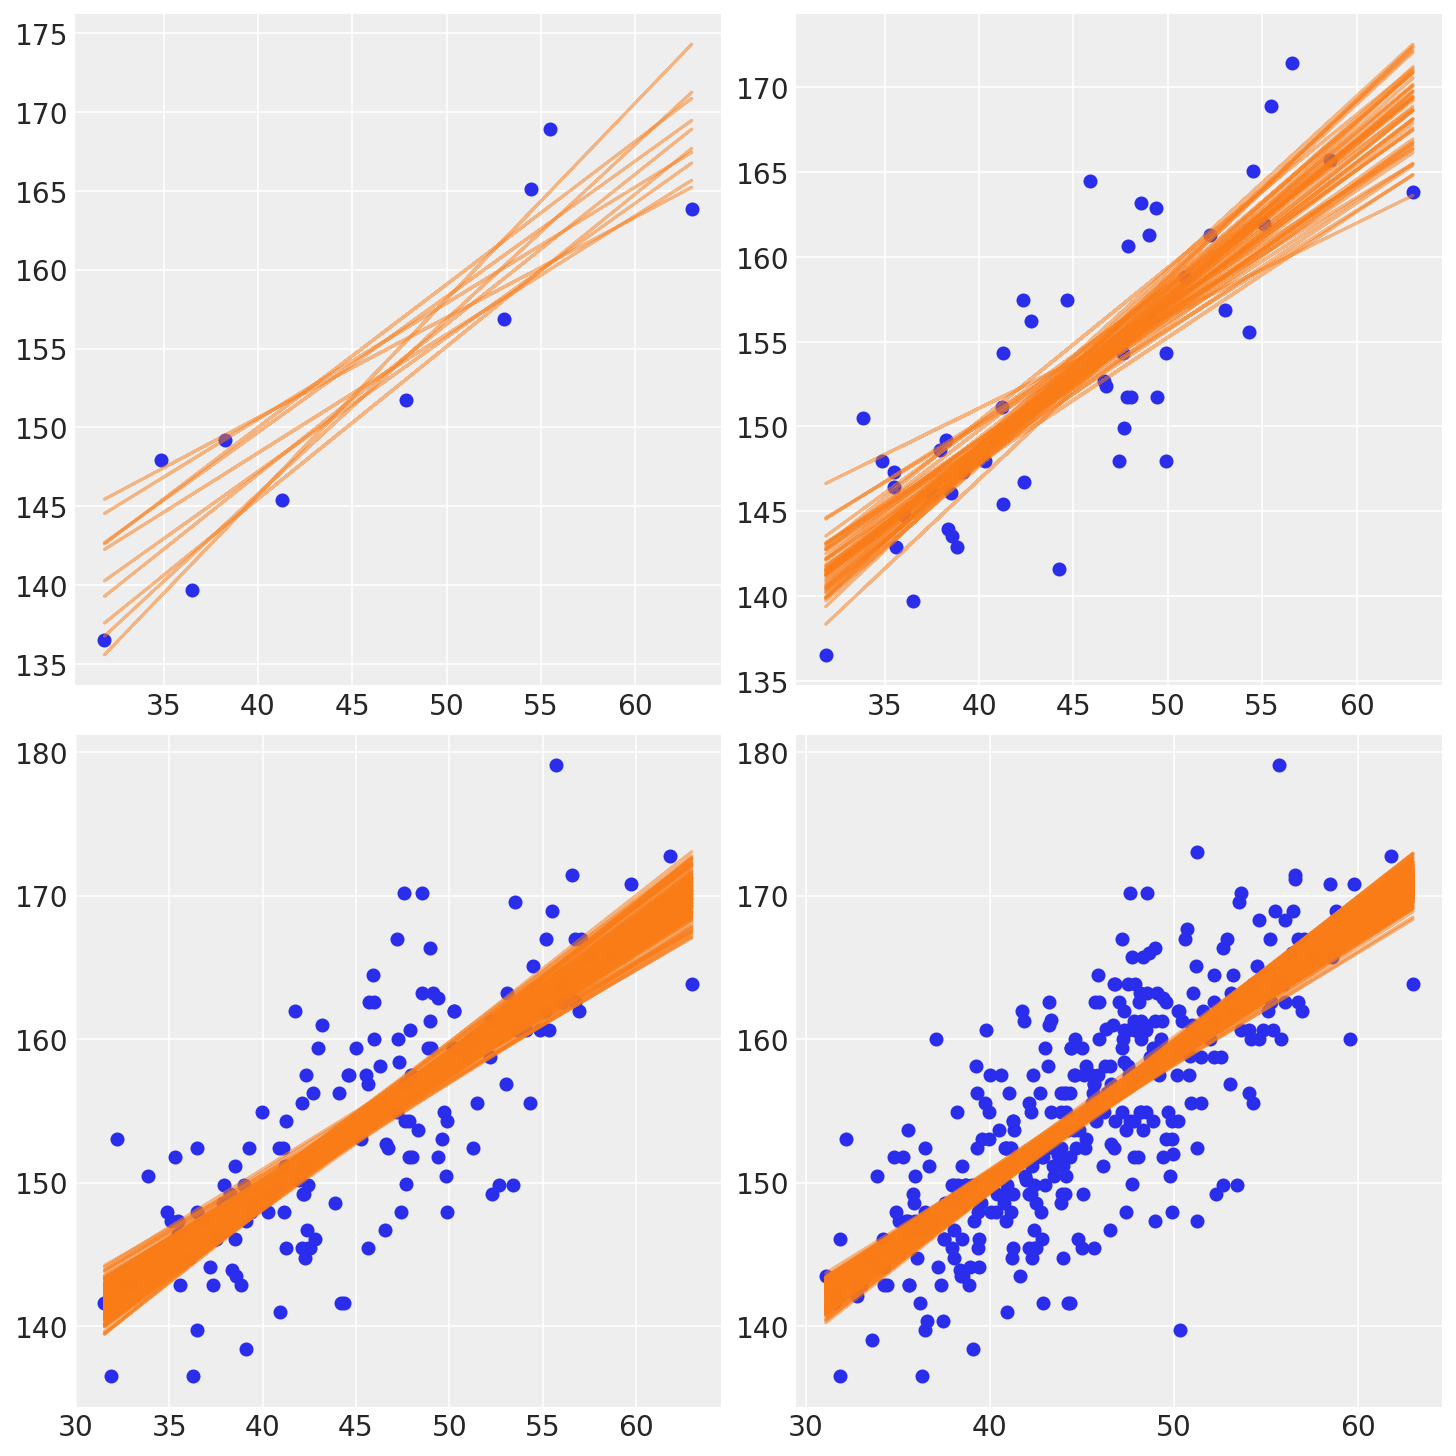

In [55]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
cords = [(0, 0), (0, 1), (1, 0), (1, 1)]
for i in range(len(data)):
    idxs = height_rng.integers(nb_samples, size=N[i])
    ax[cords[i]].plot(data[i].weight, data[i].height, "C0o")
    for idx in idxs:
        ax[cords[i]].plot(
            data[i].weight, az.extract_dataset(traces[i])["mu"][:, idx], "C1-", alpha=0.5
        )

#### Code 4.50

In [56]:
data_4_3 = az.extract_dataset(trace_4_3)
mu_at_50 = data_4_3["a"] + data_4_3["b"] * (50 - d2.weight.mean())

#### Code 4.51

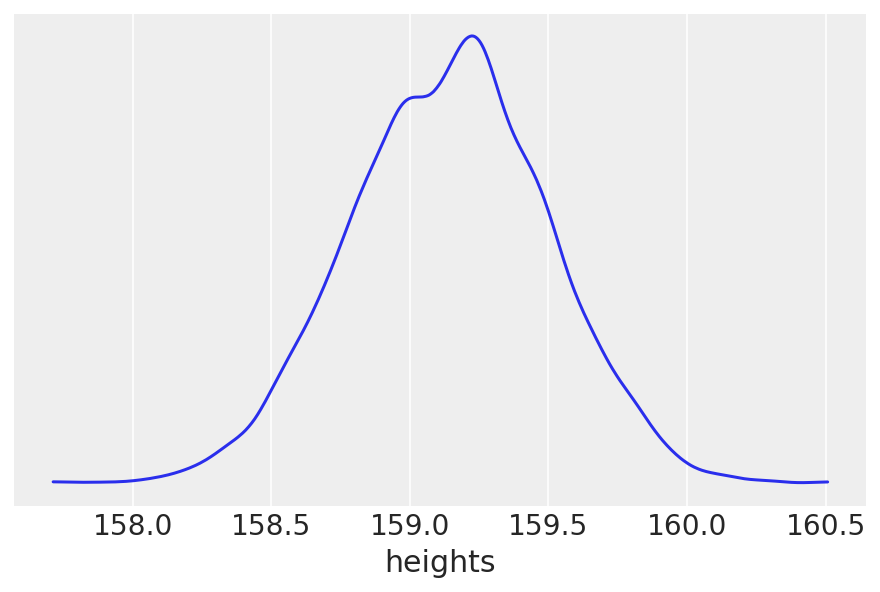

In [57]:
az.plot_kde(mu_at_50.values)
plt.xlabel("heights")
plt.yticks([]);

#### Code 4.52

In [58]:
az.hdi(mu_at_50.values, hdi_prod=0.89)

array([158.55793462, 159.69245578])

#### Code 4.53 and 4.54

We are doing _manually_, in the book is done using the ```link``` function. In the book on code 4.58 the following operations are performed _manually_.

In [59]:
weight_seq = np.arange(25, 71)
# Given that we have a lot of samples we can use less of them for plotting (or we can use all!)
nb_samples = trace_N.sizes["sample"]
trace_4_3_thinned = data_4_3.isel(sample=range(0, nb_samples, 10))
nb_samples_thinned = trace_4_3_thinned.sizes["sample"]

mu_pred = np.zeros((len(weight_seq), nb_samples_thinned))
for i, w in enumerate(weight_seq):
    mu_pred[i] = trace_4_3_thinned["a"] + trace_4_3_thinned["b"] * (w - d2.weight.mean())

#### Code 4.55

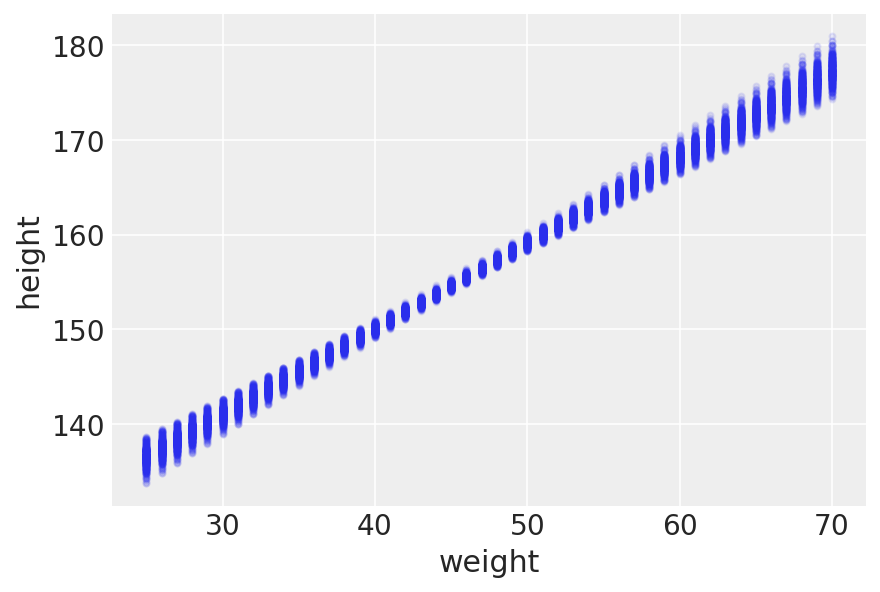

In [60]:
plt.plot(weight_seq, mu_pred, "C0.", alpha=0.1)
plt.xlabel("weight")
plt.ylabel("height");

#### Code 4.56

In [61]:
mu_mean = mu_pred.mean(1)
mu_hdi = az.hdi(mu_pred.T)

C:\Users\mason\AppData\Local\Temp\ipykernel_4580\2684262116.py:2: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  mu_hdi = az.hdi(mu_pred.T)


#### Code 4.57

C:\Users\mason\AppData\Local\Continuum\anaconda3\envs\stat-rethink2-pymc\lib\site-packages\arviz\plots\hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


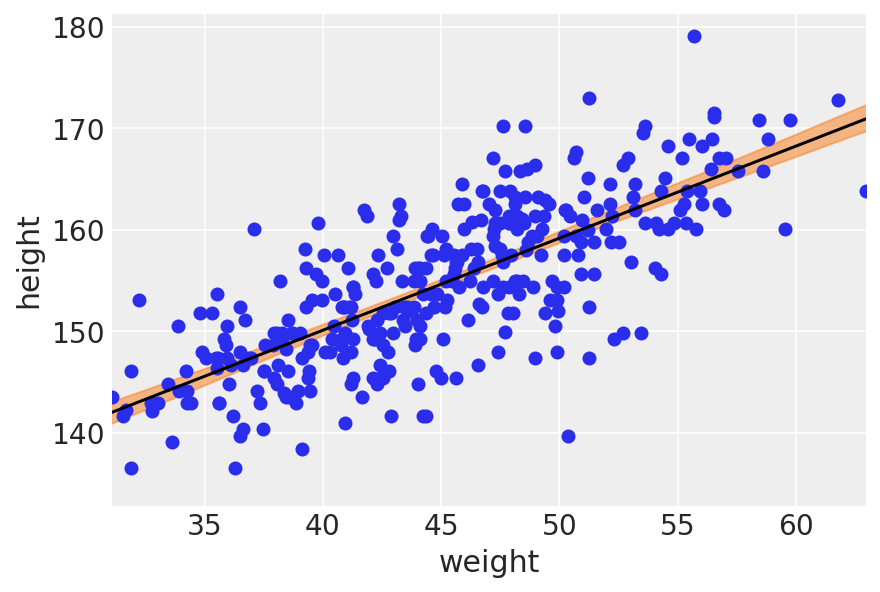

In [62]:
az.plot_hdi(weight_seq, mu_pred.T)
plt.scatter(d2.weight, d2.height)
plt.plot(weight_seq, mu_mean, "k")
plt.xlabel("weight")
plt.ylabel("height")
plt.xlim(d2.weight.min(), d2.weight.max());

#### Code 4.59

Now we are going to use ```sample_posterior_predictive()``` from PyCM. This function gives us posterior predictive samples, that is for each value of the input variable we get a sample (from the posterior) of the output variable. Thus in the following example the shape of `height_pred['height'].shape is (200, 352)`

In [63]:
samp_size = 100
slice_rate = int(len(trace_4_3["posterior"]["draw"]) / samp_size)
thin_data = trace_4_3.sel(draw=slice(None, None, slice_rate))
with m4_3:
    height_pred = pm.sample_posterior_predictive(thin_data)

#### Code 4.60

In [64]:
height_pred_hdi = az.hdi(height_pred.posterior_predictive["height"], hdi_prob=0.89)

#### Code 4.61

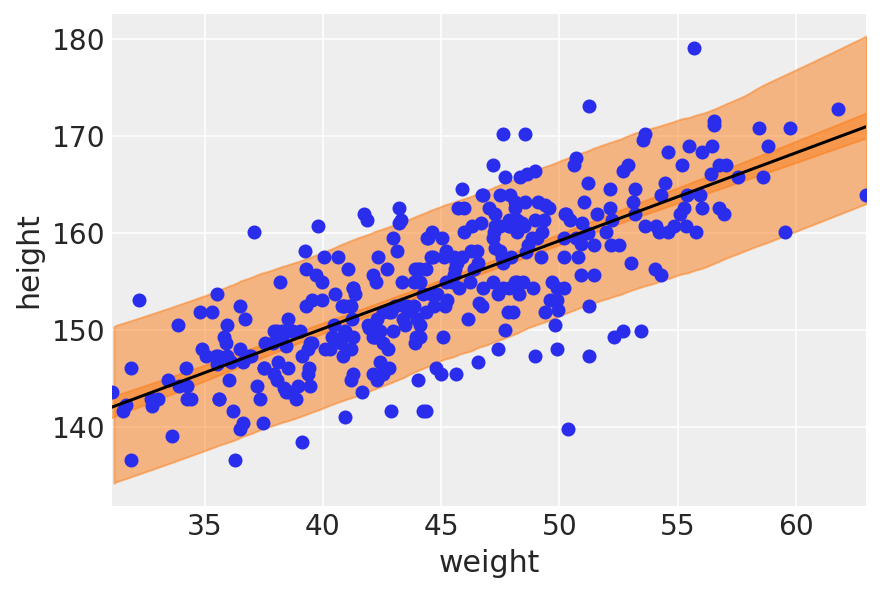

In [65]:
ax = az.plot_hdi(weight_seq, mu_pred.T, hdi_prob=0.89)
az.plot_hdi(d2.weight, height_pred.posterior_predictive["height"], ax=ax, hdi_prob=0.89)
plt.scatter(d2.weight, d2.height)
plt.plot(weight_seq, mu_mean, "k")
plt.xlabel("weight")
plt.ylabel("height")
plt.xlim(d2.weight.min(), d2.weight.max());

#### Code 4.62

Change the number of samples used in 4.59 (200) to other values.

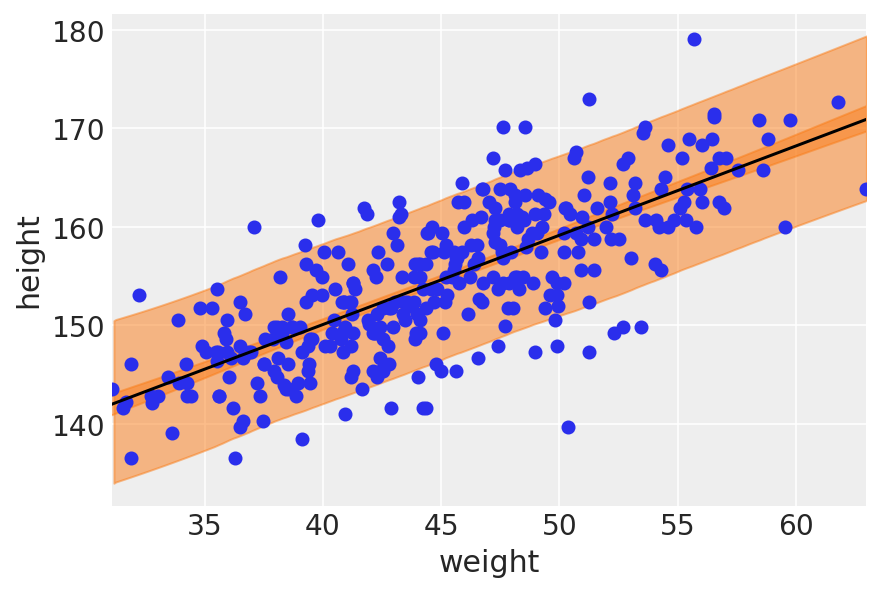

In [66]:
samp_size = 1000
slice_rate = int(len(trace_4_3["posterior"]["draw"]) / samp_size)
thin_data = trace_4_3.sel(draw=slice(None, None, slice_rate))
with m4_3:
    height_pred = pm.sample_posterior_predictive(thin_data)
ax = az.plot_hdi(weight_seq, mu_pred.T)
az.plot_hdi(d2.weight, height_pred.posterior_predictive["height"], ax=ax, hdi_prob=0.89)
plt.scatter(d2.weight, d2.height)
plt.plot(weight_seq, mu_mean, "k")
plt.xlabel("weight")
plt.ylabel("height")
plt.xlim(d2.weight.min(), d2.weight.max());

#### Code 4.63

Now we are going to generate heights from the posterior *manually*. Instead of restricting ourselves to the input values, we are going to pass an array of equally spaced weights values, called `weight_seg`.

In [67]:
weight_seq = np.arange(25, 71)
post_samples = []
for _ in range(1000):  # number of samples from the posterior
    i = height_rng.integers(len(data_4_3))
    mu_pr = data_4_3["a"][i].item(0) + data_4_3["b"][i].item(0) * (weight_seq - d2.weight.mean())
    sigma_pred = data_4_3["sigma"][i]
    post_samples.append(height_rng.normal(mu_pr, sigma_pred))

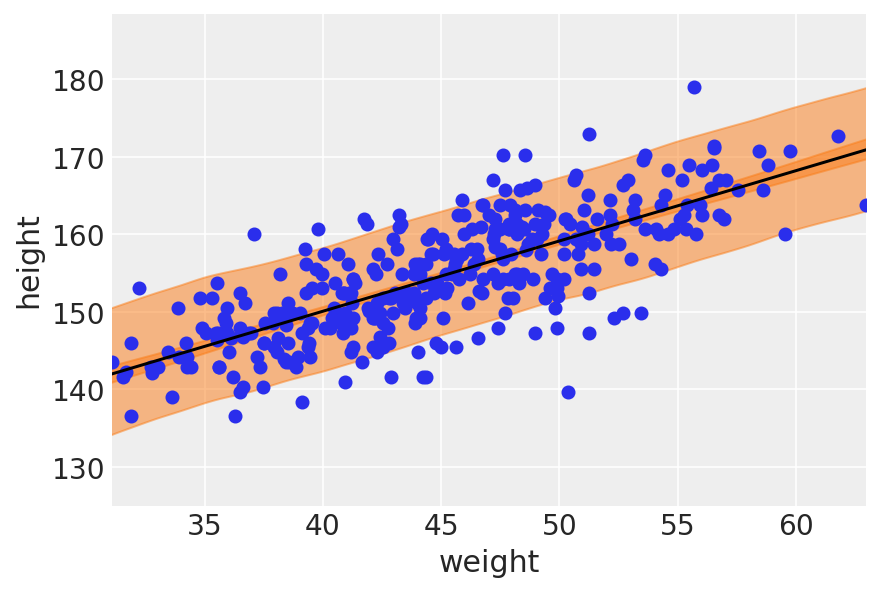

In [68]:
ax = az.plot_hdi(weight_seq, mu_pred.T, hdi_prob=0.89)
az.plot_hdi(weight_seq, np.array(post_samples), ax=ax, hdi_prob=0.89)
plt.scatter(d2.weight, d2.height)
plt.plot(weight_seq, mu_mean, "k")
plt.xlabel("weight")
plt.ylabel("height")
plt.xlim(d2.weight.min(), d2.weight.max());

#### Code 4.64

We have already loaded this dataset, check code 4.7 and 4.8.

In [69]:
d.head()

height     weight   age  male
0  151.765  47.825606  63.0     1
1  139.700  36.485807  63.0     0
2  136.525  31.864838  65.0     0
3  156.845  53.041914  41.0     1
4  145.415  41.276872  51.0     0

Text(0.5, 0, 'weight')

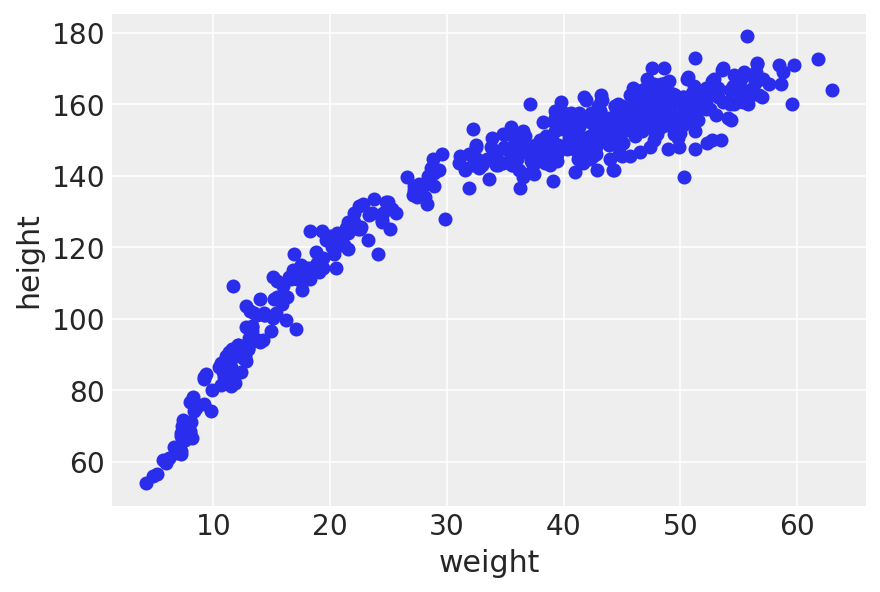

In [70]:
plt.scatter(d.weight, d.height)
plt.ylabel("height")
plt.xlabel("weight")

#### Code 4.65

In [71]:
d["weight_std"] = (d.weight - d.weight.mean()) / d.weight.std()
d["weight_std2"] = d.weight_std**2

with pm.Model() as m_4_5:
    a = pm.Normal("a", mu=178, sigma=100)
    b1 = pm.Lognormal("b1", mu=0, sigma=1)
    b2 = pm.Normal("b2", mu=0, sigma=1)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    mu = pm.Deterministic("mu", a + b1 * d.weight_std.values + b2 * d.weight_std2.values)
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d.height.values)
    trace_4_5 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b1, b2, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


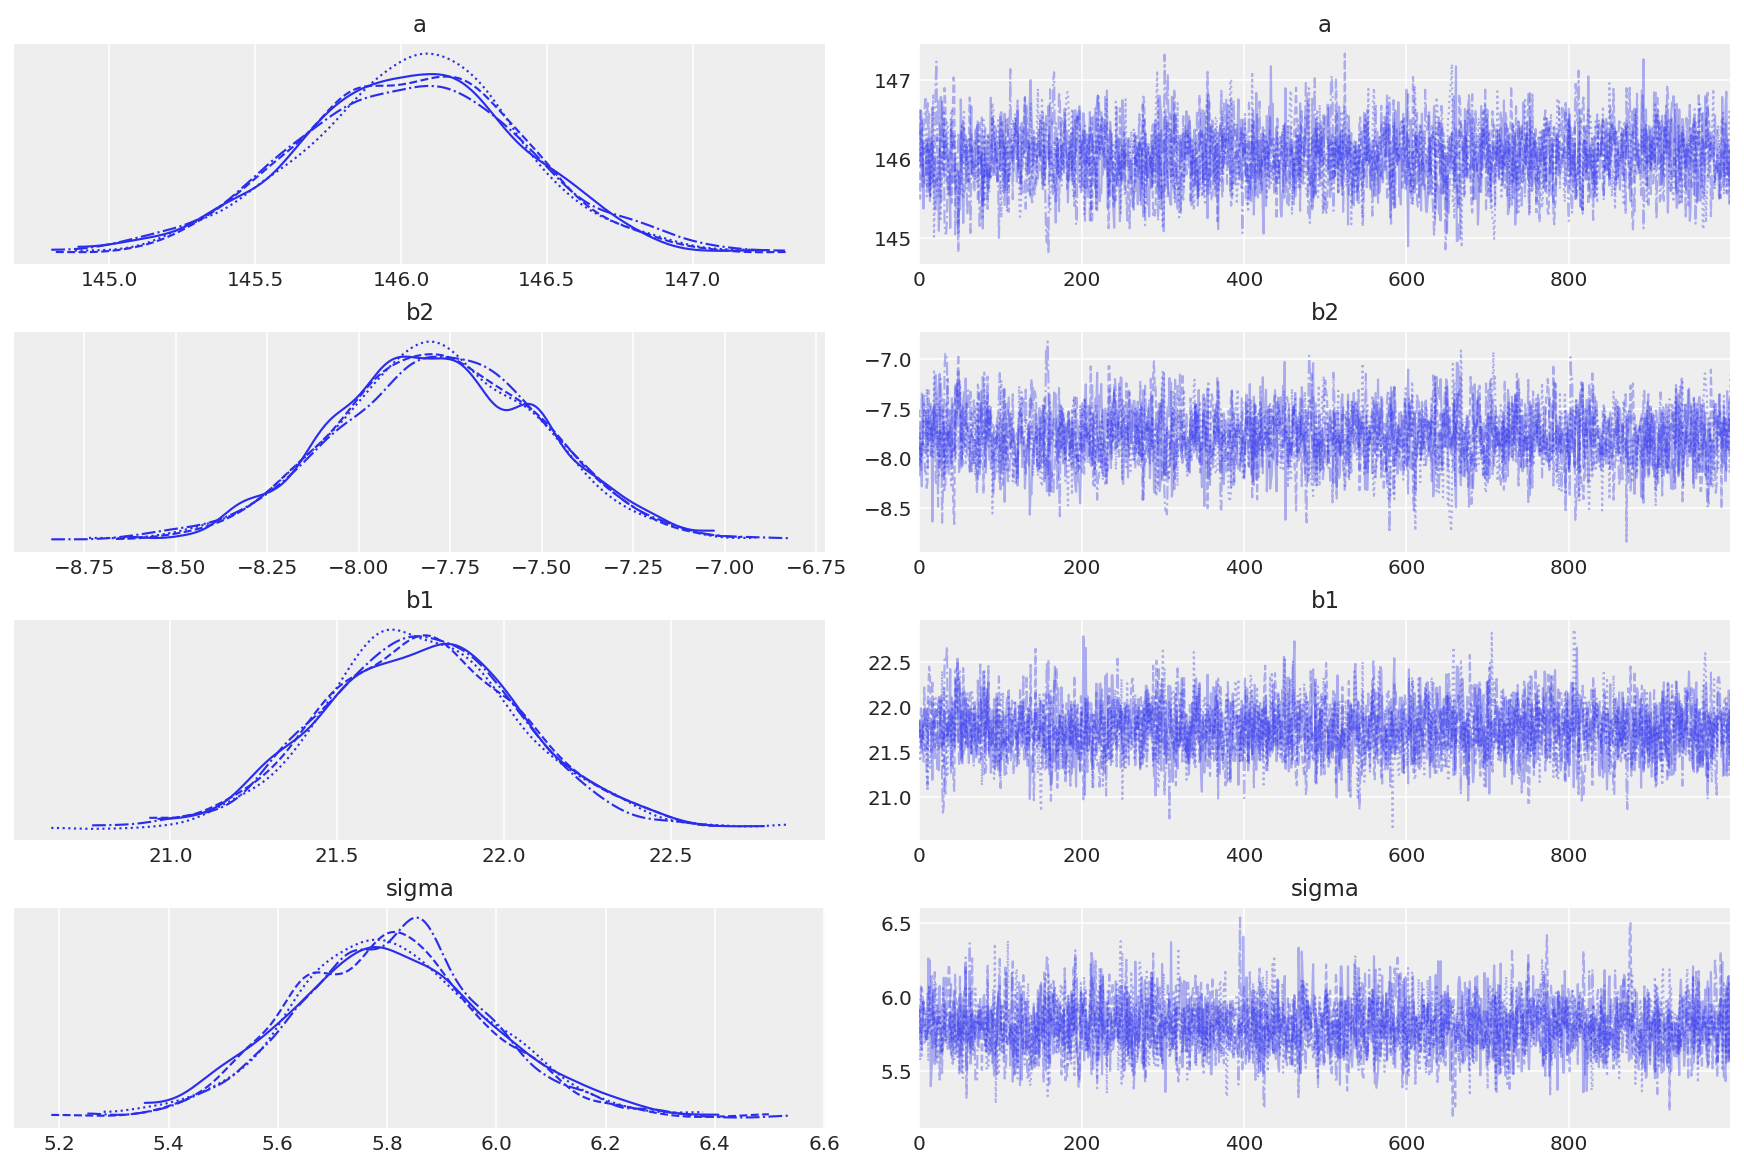

In [72]:
varnames = ["~mu"]
az.plot_trace(trace_4_5, varnames);

#### Code 4.66

In [73]:
az.summary(trace_4_5, varnames, kind="stats", round_to=2)

mean    sd  hdi_5.5%  hdi_94.5%
a      146.03  0.38    145.41     146.62
b2      -7.78  0.28     -8.21      -7.31
b1      21.75  0.30     21.29      22.24
sigma    5.80  0.18      5.53       6.10

#### Code 4.67

In [74]:
mu_pred = trace_4_5.posterior["mu"]
trace_4_5_thinned = trace_4_5.sel(draw=slice(None, None, 5))
with m_4_5:
    height_pred = pm.sample_posterior_predictive(trace_4_5_thinned)

#### Code 4.68

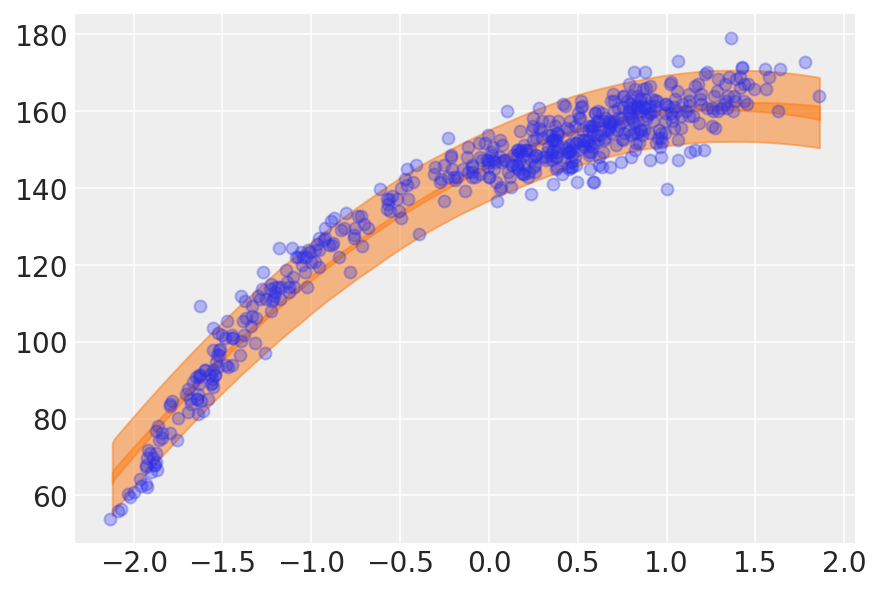

In [75]:
ax = az.plot_hdi(d.weight_std, mu_pred, hdi_prob=0.89)
az.plot_hdi(d.weight_std, height_pred.posterior_predictive["height"], ax=ax, hdi_prob=0.89)
plt.scatter(d.weight_std, d.height, c="C0", alpha=0.3)

#### Code 4.69

We will stack the weights to get a 2D array, this simplifies writing a model. Now we can compute the dot product between beta and the 2D-array

In [76]:
weight_m = np.vstack((d.weight_std, d.weight_std**2, d.weight_std**3))
weight_m

array([[ 8.29868948e-01,  5.94590878e-02, -2.54482930e-01, ...,
         1.25359437e+00, -1.87234364e+00,  1.14958904e+00],
       [ 6.88682470e-01,  3.53538312e-03,  6.47615617e-02, ...,
         1.57149885e+00,  3.50567069e+00,  1.32155496e+00],
       [ 5.71516197e-01,  2.10210655e-04, -1.64807120e-02, ...,
         1.97002211e+00, -6.56382021e+00,  1.51924510e+00]])

In [77]:
with pm.Model() as m_4_6:
    a = pm.Normal("a", mu=178, sigma=100)
    b = pm.Normal("b", mu=0, sigma=10, shape=3)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    mu = pm.Deterministic("mu", a + pm.math.dot(b, weight_m))
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d.height.values)
    trace_4_6 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.


#### Code 4.70 and 4.71

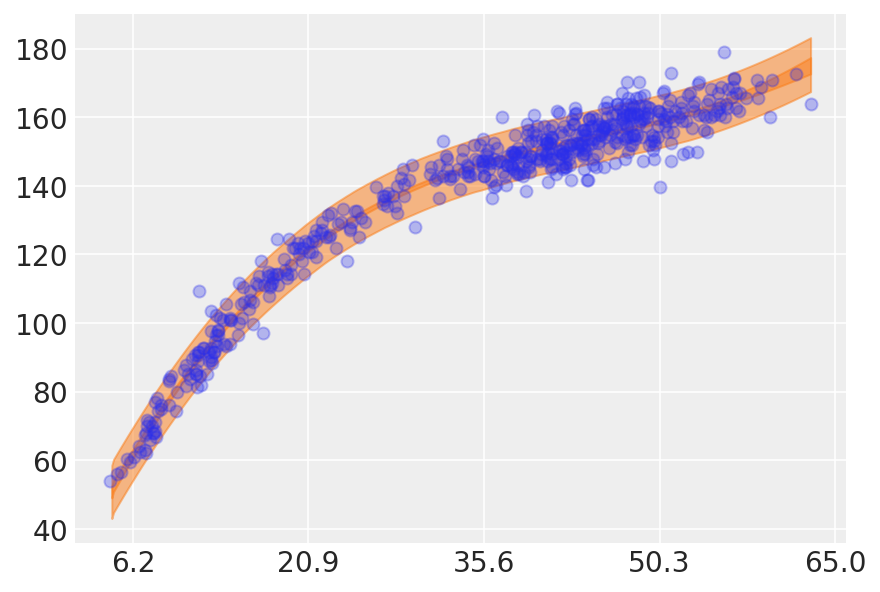

In [78]:
mu_pred = trace_4_6.posterior["mu"]
trace_4_6_thin = trace_4_6.sel(draw=slice(None, None, 5))
with m_4_6:
    height_pred = pm.sample_posterior_predictive(trace_4_6_thin)

ax = az.plot_hdi(d.weight_std, mu_pred, hdi_prob=0.89)
az.plot_hdi(d.weight_std, height_pred.posterior_predictive["height"], ax=ax, hdi_prob=0.89)
plt.scatter(d.weight_std, d.height, c="C0", alpha=0.3)

# convert x-axis back to original scale
at = np.arange(-2, 3)
labels = np.round(at * d.weight.std() + d.weight.mean(), 1)
plt.xticks(at, labels);

#### Code 4.72

In [79]:
d = pd.read_csv("Data/cherry_blossoms.csv")
# nans are not treated as in the book
az.summary(d.dropna().to_dict(orient="list"), kind="stats")

mean       sd  hdi_5.5%  hdi_94.5%
year        1533.395  291.123   1123.00    1978.00
doy          104.921    6.258     95.00     114.00
temp           6.100    0.683      5.00       7.13
temp_upper     6.938    0.812      5.57       7.98
temp_lower     5.264    0.762      4.12       6.40

Text(0, 0.5, 'day of first blossom')

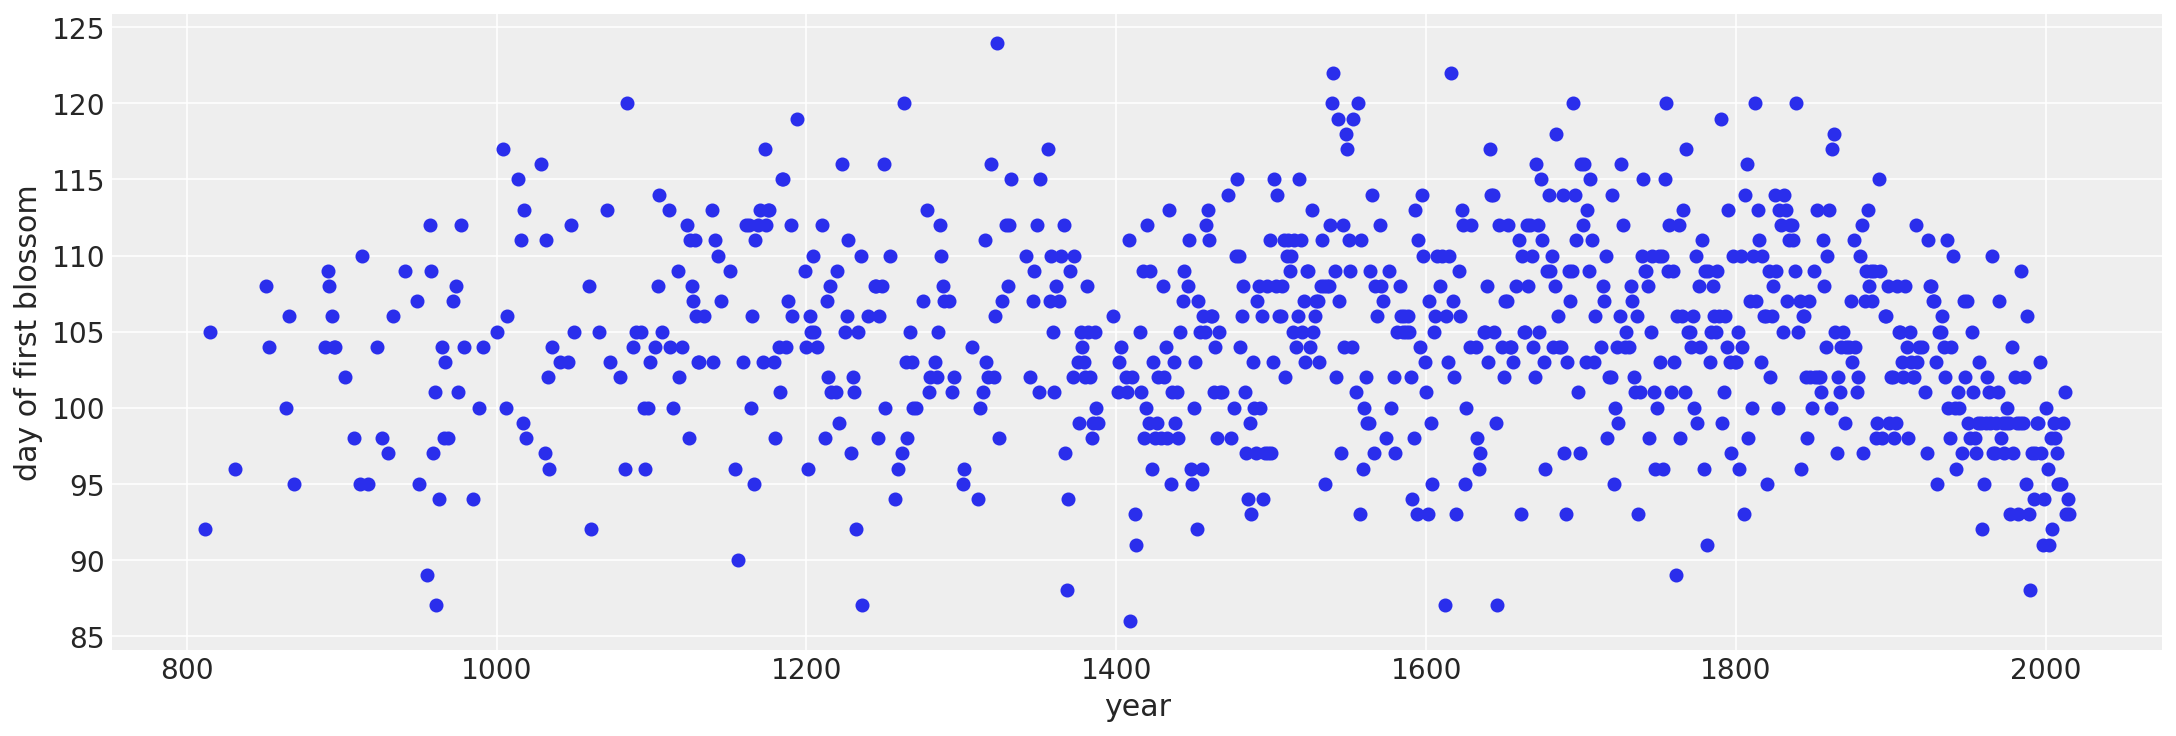

In [80]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.scatter(d.year, d.doy)
plt.xlabel("year")
plt.ylabel("day of first blossom")

#### Code 4.73

In [81]:
d2 = d.dropna(subset=["doy"])
num_knots = 15
knot_list = np.quantile(d2.year, np.linspace(0, 1, num_knots))

#### Code 4.74

Here we will use patsy as a simple way of building the b-spline matrix. For more detail please read https://patsy.readthedocs.io/en/latest/spline-regression.html

In [82]:
from patsy import dmatrix

B = dmatrix(
    "bs(year, knots=knots, degree=3, include_intercept=True)-1",
    {"year": d2.year.values, "knots": knot_list[1:-1]},
)

#### Code 4.75

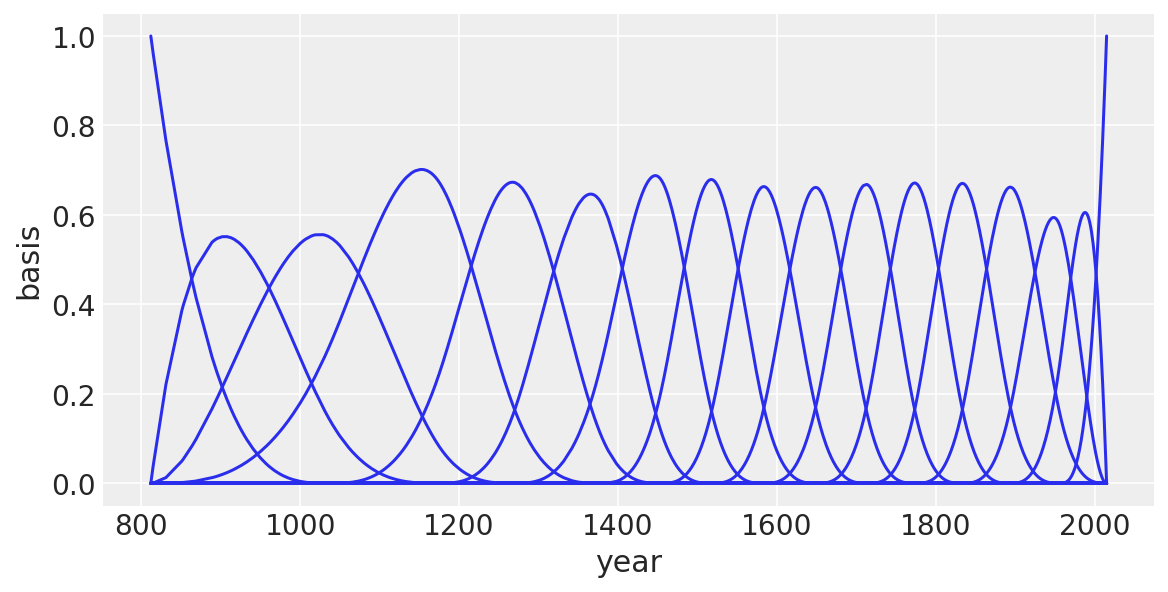

In [83]:
_, ax = plt.subplots(1, 1, figsize=(8, 4))
for i in range(B.shape[1]):
    ax.plot(d2.year, (B[:, i]), color="C0")
ax.set_xlabel("year")
ax.set_ylabel("basis");

#### Code 4.76

Note: if the model gets stalled instead of sampling try replacing `mu = pm.Deterministic("mu", a + pm.math.dot(B.base, w.T))` with `mu = pm.Deterministic("mu", a + pm.math.dot(np.asarray(B, order="F"), w.T))`

In [84]:
with pm.Model() as m4_7:
    a = pm.Normal("a", 100, 10)
    w = pm.Normal("w", mu=0, sigma=10, shape=B.shape[1])
    # mu = pm.Deterministic("mu", a + pm.math.dot(np.asarray(B, order="F"), w.T))
    mu = pm.Deterministic("mu", a + pm.math.dot(B.base, w.T))
    sigma = pm.Exponential("sigma", 1)
    D = pm.Normal("D", mu, sigma, observed=d2.doy.values)
    trace_m4_7 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, w, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 321 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6234, but should be close to 0.8. Try to increase the number of tuning steps.


#### Code 4.77

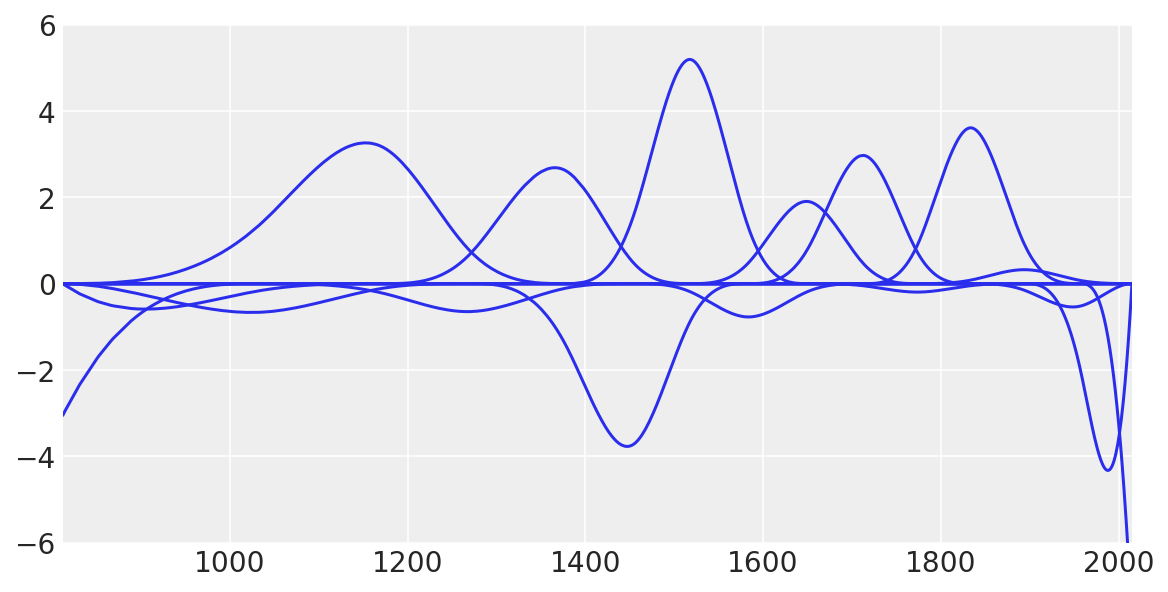

In [85]:
_, ax = plt.subplots(1, 1, figsize=(8, 4))
wp = trace_m4_7.posterior.w.mean(dim=["chain", "draw"])
for i in range(17):
    ax.plot(d2.year, (wp[i].item(0) * B[:, i]), color="C0")
ax.set_xlim(812, 2015)
ax.set_ylim(-6, 6);

#### Code 4.78

Text(0, 0.5, 'days in year')

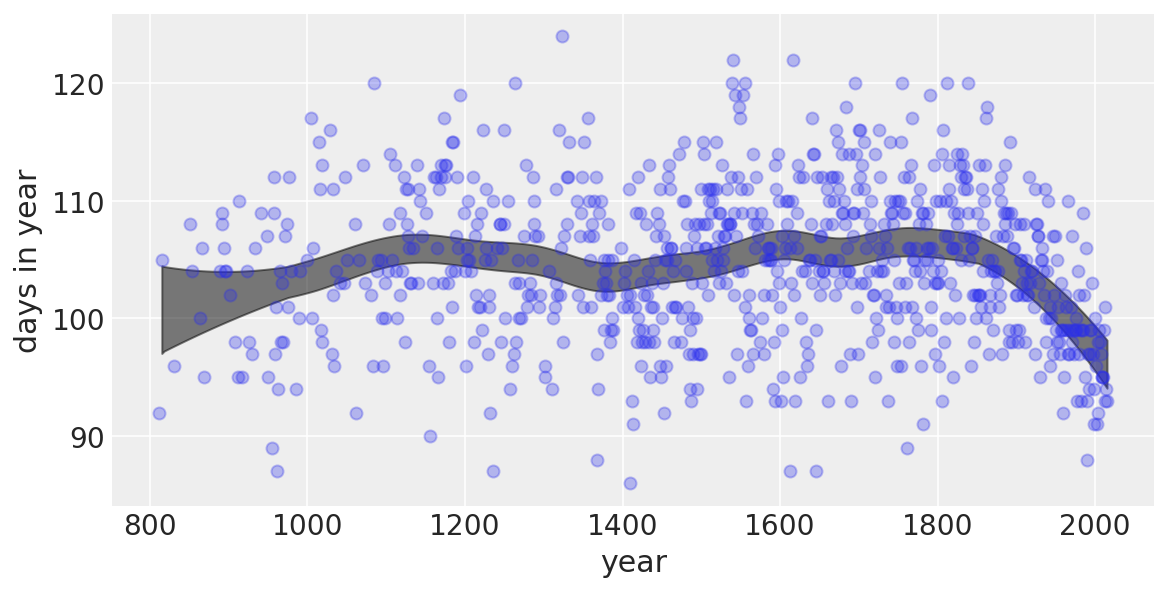

In [86]:
ax = az.plot_hdi(d2.year, trace_m4_7.posterior["mu"], color="k")
ax.plot(d2.year, d2.doy, "o", alpha=0.3)
fig = plt.gcf()
fig.set_size_inches(8, 4)
ax.set_xlabel("year")
ax.set_ylabel("days in year")

In [87]:
%load_ext watermark
%watermark -n -u -v -iv -w -p aesara,aeppl,xarray

Last updated: Fri Jul 22 2022

Python implementation: CPython
Python version       : 3.9.13
IPython version      : 8.4.0

aesara: 2.6.6
aeppl : 0.0.31
xarray: 2022.3.0

matplotlib: 3.5.2
arviz     : 0.12.1
pymc      : 4.0.0
scipy     : 1.7.3
pandas    : 1.4.2
numpy     : 1.22.1

Watermark: 2.3.1

